<h1 style="text-align:center">NLP Capstone Project - Industrial Safety</h1>


In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import string
import cv2
import os
import re
import spacy
import nlpaug.augmenter.word as naw
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import losses
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, SeparableConv1D
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dense, Activation, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, SpatialDropout1D

import pickle

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installing nlpaug for text augmentation

!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 8.3 MB/s eta 0:00:00


In [ ]:
# Downloading spaCy's English pipeline package for text processing

!python -m spacy download en_core_web_lg

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-01-13 09:37:19.574532: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
print(sns.__version__)
print(matplotlib.__version__)

0.12.1
3.6.2


### Milestone 1:
***

<h4 style="color:indianred"><em>1. <ins>Import the data:</ins></em></h4>

In [ ]:
indus_safety = pd.read_csv('/content/drive/MyDrive/AIML/Capstone/Data Set - industrial_safety_and_health_database_with_accidents_description.csv', index_col=0)
indus_safety.head()

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [ ]:
indus_safety.shape

(425, 10)

In [ ]:
indus_safety.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 0 to 438
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Data                      425 non-null    object
 1   Countries                 425 non-null    object
 2   Local                     425 non-null    object
 3   Industry Sector           425 non-null    object
 4   Accident Level            425 non-null    object
 5   Potential Accident Level  425 non-null    object
 6   Genre                     425 non-null    object
 7   Employee or Third Party   425 non-null    object
 8   Critical Risk             425 non-null    object
 9   Description               425 non-null    object
dtypes: object(10)
memory usage: 36.5+ KB


In [ ]:
indus_safety.describe()

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
count,425,425,425,425,425,425,425,425,425,425
unique,287,3,12,3,5,6,2,3,33,411
top,2017-02-08 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Third Party,Others,During the activity of chuteo of ore in hopper...
freq,6,251,90,241,316,143,403,189,232,3


In [ ]:
# Checking the content of a few accident descriptions

indus_safety.Description[0]

'While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.'

In [ ]:
indus_safety.Description[4]

'Approximately at 11:45 a.m. in circumstances that the mechanics Anthony (group leader), Eduardo and Eric Fernández-injured-the three of the Company IMPROMEC, performed the removal of the pulley of the motor of the pump 3015 in the ZAF of Marcy. 27 cm / Length: 33 cm / Weight: 70 kg), as it was locked proceed to heating the pulley to loosen it, it comes out and falls from a distance of 1.06 meters high and hits the instep of the right foot of the worker, causing the injury described.'

<h4 style="color:indianred"><em>2. <ins>Data cleansing:</ins></em></h4>

In [ ]:
indus_safety.columns

Index(['Data', 'Countries', 'Local', 'Industry Sector', 'Accident Level',
       'Potential Accident Level', 'Genre', 'Employee or Third Party',
       'Critical Risk', 'Description'],
      dtype='object')

<ins>Observation:</ins>
Some of the columns in the dataset have misspelt names

In [ ]:
# Replacing the misspelt column names

indus_safety.rename(columns={'Data':'Date', 
                                               'Genre':'Gender',
                                               'Countries': 'Country',
                                               'Local': 'Locality'}, 
                                                inplace=True)

In [ ]:
indus_safety.columns

Index(['Date', 'Country', 'Locality', 'Industry Sector', 'Accident Level',
       'Potential Accident Level', 'Gender', 'Employee or Third Party',
       'Critical Risk', 'Description'],
      dtype='object')

In [ ]:
# Checking for missing values in the dataset

indus_safety.isnull().sum()

Date                        0
Country                     0
Locality                    0
Industry Sector             0
Accident Level              0
Potential Accident Level    0
Gender                      0
Employee or Third Party     0
Critical Risk               0
Description                 0
dtype: int64

<ins>Observation:</ins>
There are no missing values in the dataset

In [ ]:
# Checking for duplicate values

indus_safety.duplicated().sum()

7

In [ ]:
# Removing the duplicates

indus_safety.drop_duplicates(inplace=True)

In [ ]:
indus_safety.duplicated().sum()

0

In [ ]:
indus_safety.shape

(418, 10)

In [ ]:
# Converting the 'Date' column to type 'datetime'

indus_safety.Date =pd.to_datetime(indus_safety.Date, format="%Y-%m-%d %H:%M:%S")

<h4 style="color:palevioletred"><em><ins><strong>Exploratory Data Analysis: </strong></ins></em></h4>

In [ ]:
# Checking the time period during which the observations have been taken

print(f'Start Date: {indus_safety.Date.min()}\nEnd Date: {indus_safety.Date.max()}')

Start Date: 2016-01-01 00:00:00
End Date: 2017-07-09 00:00:00


<ins><strong>Insight:</strong></ins>
The data observations span from 1st Jan, 2016 to 9th Jul, 2017. Even though, data has been collected for the entire year of 2016, only the 1st half of the observations collected in 2017 has been provided in this dataset. Hence, 'month' or  'year' will not provide any valuable insight for exploratory data analysis. Therefore, only the 'weekday' is considered for further analysis.

In [ ]:
# Feature engineering - Adding a new column 'Weekday' (the day of the week when the accident was observed)

indus_safety['Weekday'] = indus_safety.Date.dt.day_name()

In [ ]:
indus_safety.columns

Index(['Date', 'Country', 'Locality', 'Industry Sector', 'Accident Level',
       'Potential Accident Level', 'Gender', 'Employee or Third Party',
       'Critical Risk', 'Description', 'Weekday'],
      dtype='object')

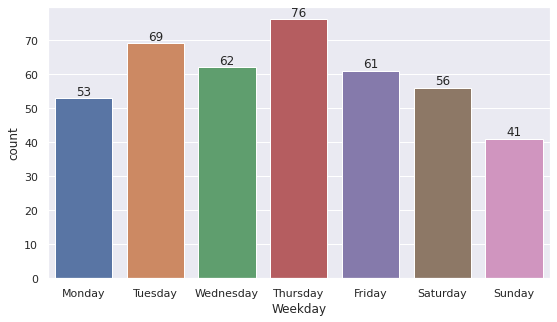

In [ ]:
# Checking the distribution of weekday 

plt.figure(figsize=(9, 5))
sns.set_theme(style="darkgrid")
sns.set_context('notebook')
ax = sns.countplot(data=indus_safety, 
                            x='Weekday',
                            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.bar_label(ax.containers[0])
plt.show()

<ins><strong>Observation:</strong></ins>
The number of accidents seem to peak during the mid-week and tapers down as the week-end approaches.

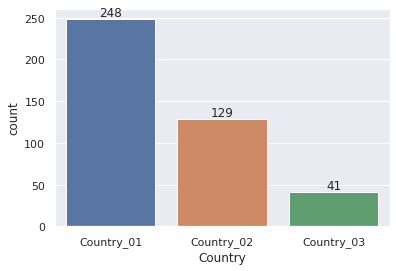

In [ ]:
# Checking the distribution of the Country where the accident occurred

sns.set_theme(style="darkgrid")
sns.set_context('notebook')
ax = sns.countplot(data=indus_safety, 
                            x='Country',
                            order=indus_safety['Country'].value_counts().sort_values(ascending=False).index)
ax.bar_label(ax.containers[0])
plt.show()

<ins><strong>Observation:</strong></ins>
From the above plot, it is evident that most of the accidents recorded in the dataset happened in Country_01. This needs to be further investigated into.

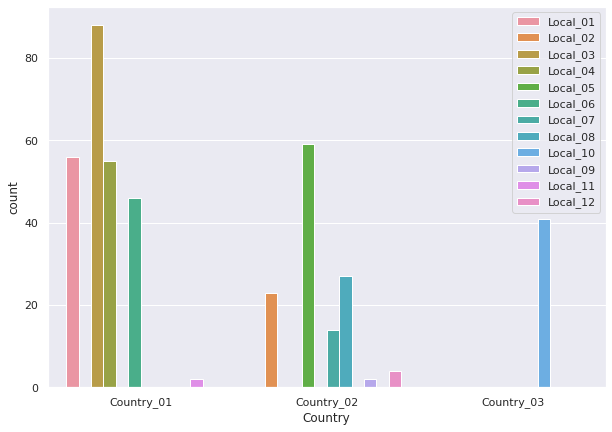

In [ ]:
# Checking which Locality belongs to which Country

plt.figure(figsize=(10, 7))
sns.set_theme(style="darkgrid")
sns.set_context('notebook')
ax = sns.countplot(data=indus_safety,
                            x='Country', 
                            hue='Locality')
plt.legend(loc='upper right')
plt.show()

<ins><strong>Observation:</strong></ins>
Locality-03 has the maximum number of accidents registered. Since, Locality-03 is present in Country-01, this explains why Country-01 has the maximum number of accidents among the 3 countries.

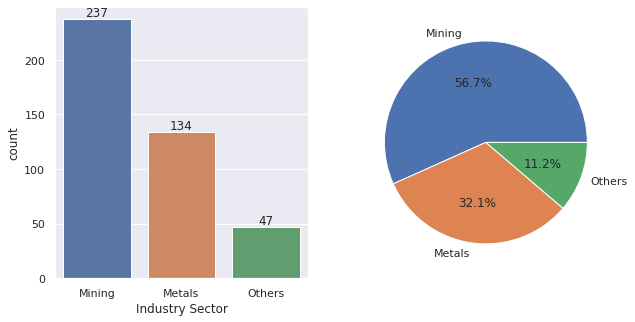

In [ ]:
# Checking the distribution of the 'Industry Sector'

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.set_theme(style="darkgrid")
sns.set_context('notebook')
sns.countplot(data=indus_safety, x='Industry Sector', ax=ax0)
ax0.bar_label(ax0.containers[0])

ax1.pie(indus_safety['Industry Sector'].value_counts(), labels=indus_safety['Industry Sector'].unique(), autopct = '%1.1f%%')
plt.show()

<ins><strong>Observation:</strong></ins>
From the above plots, one can infer that the Mining industry has much more accidents (56.7%) than the other industries. The mining industry has a reputation for being a risky business, with health risks that are varied and often quite serious. By introducing strict safety legislation and protocol, as well as using advanced safety equipment, it is possible to reduce the accidents pertaining to this sector.



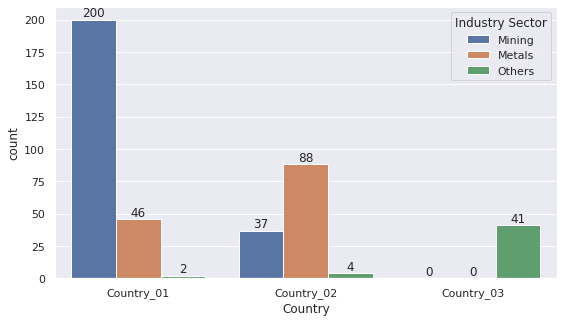

In [ ]:
# Checking the distribution of the 'Industry Sector' by Country 

plt.figure(figsize=(9,5))
sns.set_theme(style="darkgrid")
sns.set_context('notebook')
ax = sns.countplot(data=indus_safety, 
                     x='Country', 
                     hue='Industry Sector')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

<ins><strong>Observation:</strong></ins>
Most of the mines are situated in Country_01 and mining, being the riskiest of the industry sectors, has recorded the maximum number of accidents in the dataset. This clearly explains why Country_01 tops the list of the most accident-prone country in the dataset. Since, Locality-03 is located in Country-01 and has recorded the maximum number of accidents, it is very much possible that Locality-03 is a 'mining' industry.

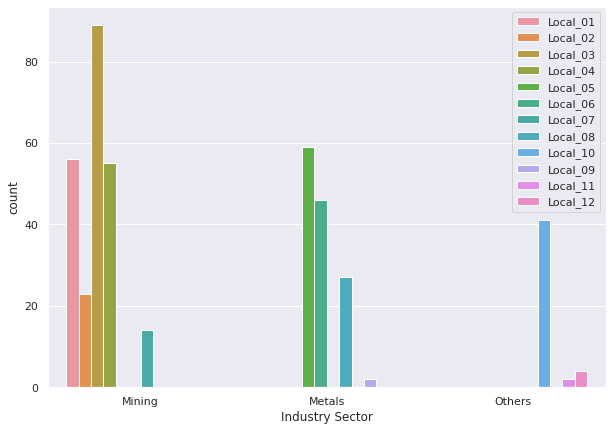

In [ ]:
# Checking which Locality belongs to which industry

plt.figure(figsize=(10, 7))
sns.set_theme(style="darkgrid")
sns.set_context('notebook')
ax = sns.countplot(data=indus_safety,
                            x='Industry Sector', 
                            hue='Locality')
plt.legend(loc='upper right')
plt.show()

<ins><strong>Observation:</strong></ins>
From the above plot, it is clear that 
1. Locality-01, Locality-02, Locality-03, 
Locality-04 and Locality-07 belongs to the Mining industry. 
2. Locality-04, Locality-05, Locality-08 and Locality-9 belong to the Metals industry.
3. Locality-10, Locality-11 and Locality-12 belongs to Others

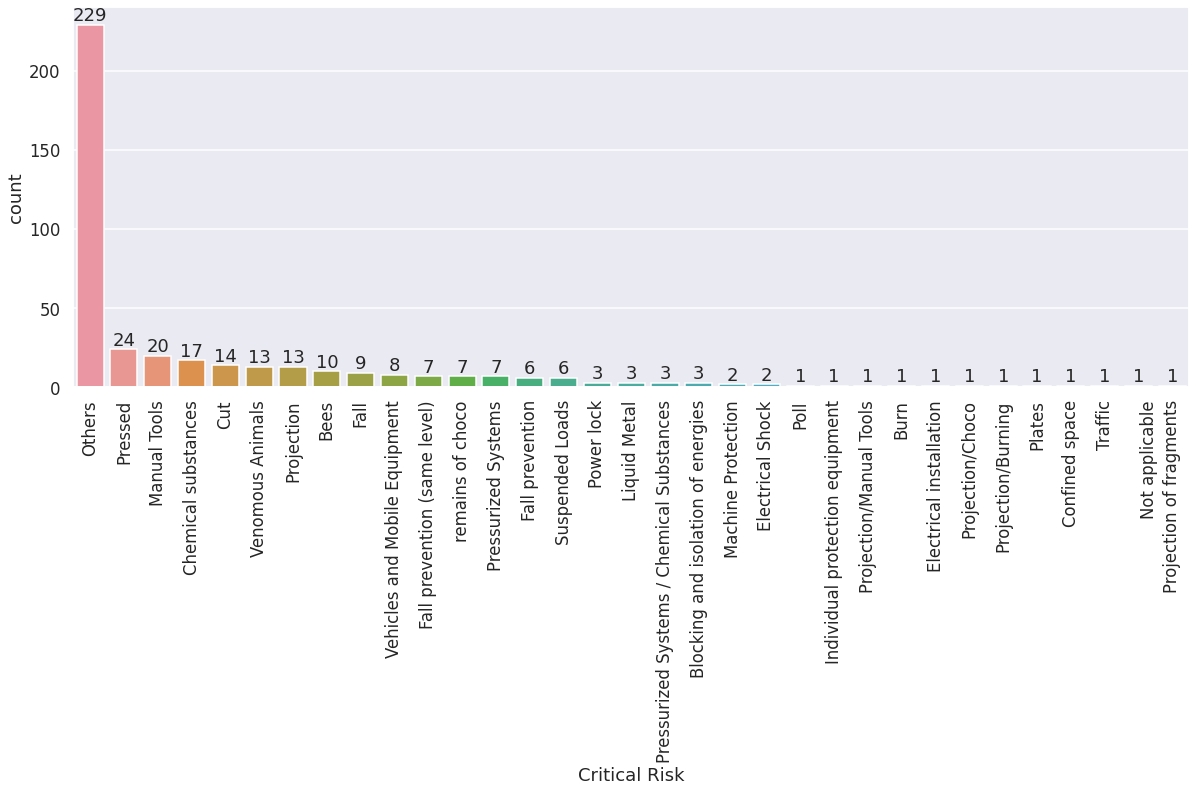

In [ ]:
# Checking the distribution of 'Critical Risk'

plt.figure(figsize=(20,7))
sns.set_theme(style="darkgrid")
sns.set_context('talk')
ax = sns.countplot(x=indus_safety['Critical Risk'], 
                            order=indus_safety['Critical Risk'].value_counts().sort_values(ascending=False).index)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()

<ins><strong>Observation:</strong></ins>
Several factors in ‘Critical Risk’ have only 1, 2 or 3 incidences of occurrence. The data is heavily imbalanced towards ‘Other’ factor. It is not clear what this 'Other' factor indicates. It looks like critical risk factors that have unknown causes are categorized as 'Other'.



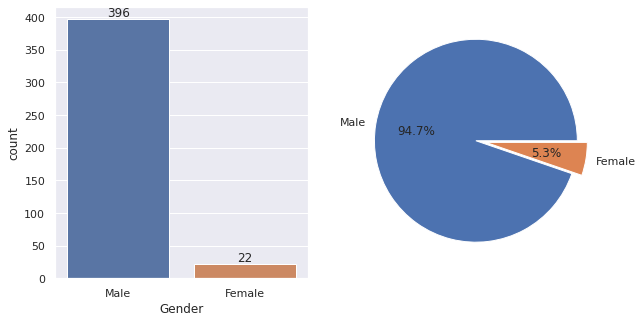

In [ ]:
# Checking the distribution of 'Gender'

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.set_theme(style="darkgrid")
sns.set_context('notebook')
sns.countplot(data=indus_safety, x='Gender', ax=ax0)
ax0.bar_label(ax0.containers[0])

ax1.pie(indus_safety['Gender'].value_counts(), labels=indus_safety['Gender'].unique(),  explode=(0.1,0), autopct = '%1.1f%%')
plt.show()

<ins><strong>Observation:</strong></ins>
The male seem to be the most affected, accounting for almost 95% of the accidents. This could also be the case where men are more employed than women as mining and metal are primarily male-driven industries. 

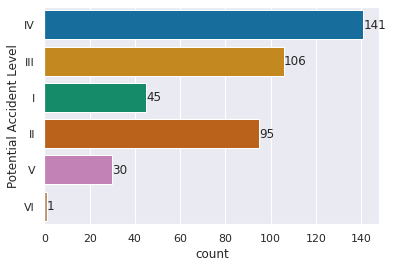

In [ ]:
# Checking the distribution of the target variable - 'Potential Accident Level'

sns.set_theme(style="darkgrid")
sns.set_context('notebook')
ax = sns.countplot(data=indus_safety,
                            y='Potential Accident Level', 
                            palette='colorblind')
ax.bar_label(ax.containers[0])
plt.show()

<ins><b>Observation:</b></ins>
    The distribution of the target classes varies significantly, implying some imbalance in the dataset. Since the Potential Accident Level 'VI' has only one sample, it can be safely removed, as it is insufficient for training the model.

In [ ]:
indus_safety[indus_safety['Potential Accident Level']=='VI']

,Date,Country,Locality,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee or Third Party,Critical Risk,Description
321,2017-01-25 00:00:00,Country_01,Local_03,Mining,V,VI,Male,Third Party,remains of choco,During the process of loading drills in the Ca...


In [ ]:
# Dropping 'row 321' as it does not contribute to the model

indus_safety.drop(321, axis=0, inplace=True)

In [ ]:
indus_safety.shape

(417, 10)

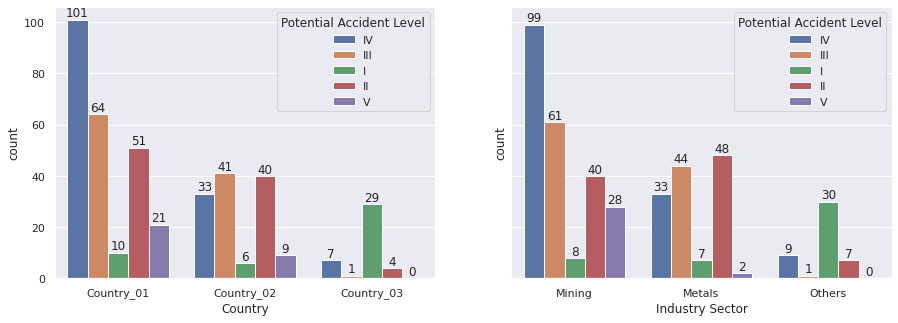

In [ ]:
# Checking the distribution of the 'Potential Accident Level' by Country and Industry Sector

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)
sns.set_theme(style="darkgrid")
sns.set_context('notebook')
sns.countplot(data=indus_safety, 
                     x='Country', 
                     hue='Potential Accident Level', 
                     ax=ax0)
for container in ax0.containers:
    ax0.bar_label(container)

sns.countplot(data=indus_safety, 
                     x='Industry Sector', 
                     hue='Potential Accident Level',
                     ax=ax1)
for container in ax1.containers:
    ax1.bar_label(container)

plt.show()

<ins><strong>Observation:</strong></ins>
Severe accidents, of the order of Level IV and Level V, have been recorded in Country_01 and in the Mining industry. Most of the mines are present in Country_01, and mining being a very risky industry has significantly contributed to severe accidents owing to its hazardous working conditions.

<h4 style="color:indianred"><em>3. <ins>Data preprocessing (NLP Preprocessing techniques):</ins></em></h4>

In [ ]:
# Loading the large English language model from spaCy

nlp = spacy.load("en_core_web_lg")

In [ ]:
# Getting the list of stopwords from spaCy

stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
# Function to preprocess text data using spaCy

def text_preprocessing(text):
    """Preprocess text data.  
    
    Args:    
        text (str): The description text.
        
    Returns:    
        (str): The preprocessed text data.
    """
    # Creating a doc object and lowercasing the text data
    doc = nlp(text.lower(), disable=['ner', 'parser'])

    # Generating the list of lemmas and removing stopwords, special characters, numbers and extra white spaces
    alpha_lemmas = [lemma for lemma in [token.lemma_ for token in doc] if lemma.isalpha() and lemma not in stop_words]
    
    return ' '.join(alpha_lemmas)

In [ ]:
# Text Data preprocessing

indus_safety['Preprocessed Description']= indus_safety.Description.apply(text_preprocessing)

In [ ]:
indus_safety.head()

,Date,Country,Locality,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee or Third Party,Critical Risk,Description,Preprocessed Description
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,remove drill rod jumbo maintenance supervisor ...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,activation sodium sulphide pump piping uncoupl...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,sub station milpo locate level collaborator ex...
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,approximately nv personnel begin task unlock s...
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,approximately circumstance mechanic anthony gr...


In [ ]:
# Unprocessed text data

indus_safety.Description[4]

'Approximately at 11:45 a.m. in circumstances that the mechanics Anthony (group leader), Eduardo and Eric Fernández-injured-the three of the Company IMPROMEC, performed the removal of the pulley of the motor of the pump 3015 in the ZAF of Marcy. 27 cm / Length: 33 cm / Weight: 70 kg), as it was locked proceed to heating the pulley to loosen it, it comes out and falls from a distance of 1.06 meters high and hits the instep of the right foot of the worker, causing the injury described.'

In [ ]:
# Cleaned up text data

indus_safety['Preprocessed Description'][4]

'approximately circumstance mechanic anthony group leader eduardo eric fernández injure company impromec perform removal pulley motor pump zaf marcy cm length cm weight kg lock proceed heat pulley loosen come fall distance meter high hit instep right foot worker cause injury describe'

In [ ]:
# Function to return the median number of words per sample

def get_num_words_per_sample(sample_texts):
    """Return the median number of words per sample.

    Args:
        sample_texts (list): list of texts.

    Returns:
        (int): median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

In [ ]:
# Number of words per sample for Industrial safety Accident Description

print('Number of words per sample:')
print(f'Description: {get_num_words_per_sample(indus_safety.Description)}')
print(f'Preprocessed Description: {get_num_words_per_sample(indus_safety["Preprocessed Description"])}')

Number of words per sample:
Description: 60.0
Preprocessed Description: 28.0


In [ ]:
# Function to plot the distribution of the sample lengths

def plot_sample_length_distribution(sample_texts_1, sample_texts_2):
    """Plot the distribution of the sample lengths.

    Args:
        sample_texts_1 (list): List of texts.
        sample_texts_1 (list): List of texts
    """
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
    sns.set_style('darkgrid')
    sns.set_context('notebook')
    sns.histplot([len(s) for s in sample_texts_1], color='palevioletred', ax=ax0)
    sns.histplot([len(s) for s in sample_texts_2], color='seagreen', ax=ax1)
    plt.ylabel('Number of samples')
    ax0.set(xlabel='Length of a sample', title='Sample length distribution of unprocessed text')
    ax1.set(xlabel='Length of a sample', title='Sample length distribution of processed text')
    plt.show()

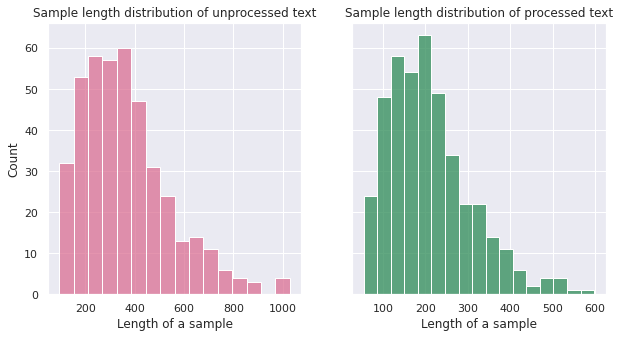

In [ ]:
# Sample Length Distribution of Industrial safety Accident Description

plot_sample_length_distribution(indus_safety.Description, indus_safety['Preprocessed Description'])

<em><strong>Observation:</strong></em>
The sample length distribution of both unprocessed and processed text seem to be very similar.

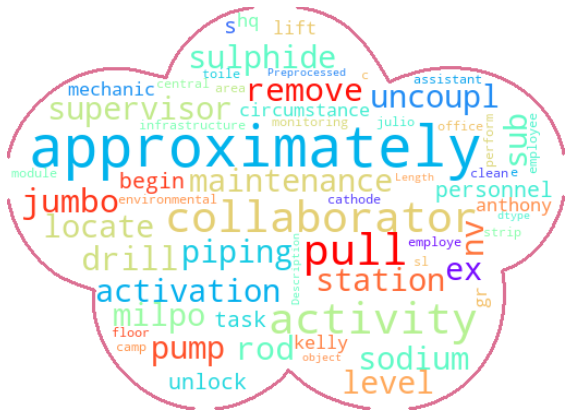

In [ ]:
# Word Cloud Image mask
image_mask = cv2.imread('/content/drive/MyDrive/AIML/Capstone/mask-cloud.png')

# Generating the word cloud image
my_cloud = WordCloud(background_color='white', 
                                   stopwords=stop_words, 
                                   mask = image_mask,
                                   collocations=False,
                                   contour_color='palevioletred',
                                   contour_width=3,
                                   colormap='rainbow').generate(str(indus_safety['Preprocessed Description']))

# Displaying the generated wordcloud image
fig = plt.figure(figsize=(10, 10)) 
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()    

<h4 style="color:indianred"><em>4. <ins>Data preparation - Cleansed data in .xlsx or .csv file: </ins></em></h4>

In [ ]:
# Saving the cleansed data in a .csv file 

indus_safety[["Preprocessed Description", "Potential Accident Level"]].to_csv('/content/drive/MyDrive/AIML/Capstone/indus_safety_cleaned.csv', index=False)

In [ ]:
# Importing the cleansed dataset

indus_safety_cleaned = pd.read_csv('/content/drive/MyDrive/AIML/Capstone/indus_safety_cleaned.csv')
indus_safety_cleaned.head()

,Preprocessed Description,Potential Accident Level
0,remove drill rod jumbo maintenance supervisor ...,IV
1,activation sodium sulphide pump piping uncoupl...,IV
2,sub station milpo locate level collaborator ex...,III
3,approximately nv personnel begin task unlock s...,I
4,approximately circumstance mechanic anthony gr...,IV


In [ ]:
# Creating dependent and independent variables

X = indus_safety_cleaned['Preprocessed Description']
y = indus_safety_cleaned['Potential Accident Level']

In [ ]:
# Label Encoding the target variable

y_enc = y.astype('category').cat.codes.values

In [ ]:
y_enc

array([3, 3, 2, 0, 3, 2, 2, 2, 3, 1, 2, 3, 0, 4, 2, 3, 3, 1, 1, 2, 1, 3,
       3, 1, 1, 1, 0, 2, 3, 2, 1, 1, 3, 4, 1, 2, 3, 4, 4, 3, 3, 3, 2, 2,
       2, 2, 2, 3, 2, 3, 3, 4, 4, 3, 3, 2, 2, 1, 1, 1, 1, 3, 2, 3, 3, 3,
       1, 3, 3, 3, 2, 2, 2, 2, 4, 2, 4, 1, 3, 0, 1, 3, 2, 2, 1, 3, 3, 3,
       2, 1, 2, 2, 1, 3, 2, 4, 1, 2, 3, 1, 2, 3, 3, 1, 3, 3, 3, 0, 3, 2,
       2, 2, 2, 1, 2, 1, 3, 3, 1, 3, 2, 2, 0, 3, 3, 2, 2, 4, 0, 0, 0, 2,
       2, 1, 4, 1, 2, 0, 2, 0, 2, 3, 0, 0, 2, 3, 3, 0, 0, 0, 0, 0, 0, 4,
       3, 2, 2, 1, 2, 3, 3, 4, 3, 1, 1, 4, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
       1, 1, 3, 3, 1, 2, 2, 0, 2, 1, 3, 3, 3, 3, 2, 3, 2, 2, 2, 1, 3, 1,
       1, 1, 1, 1, 3, 0, 2, 3, 3, 1, 1, 1, 3, 3, 1, 0, 1, 3, 0, 1, 1, 2,
       2, 3, 2, 1, 1, 0, 2, 1, 2, 1, 3, 2, 1, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 4, 3, 1, 3, 1, 3, 0, 3, 1, 1, 0, 2, 1, 3, 3, 3, 2,
       2, 1, 1, 1, 2, 1, 1, 2, 3, 1, 2, 3, 1, 3, 2, 1, 3, 4, 3, 1, 3, 2,
       0, 3, 2, 3, 2, 2, 3, 1, 3, 2, 3, 3, 3, 2, 0,

In [ ]:
# Splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.20, random_state=42, stratify=y_enc)

In [ ]:
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(333,)

(84,)

(333,)

(84,)

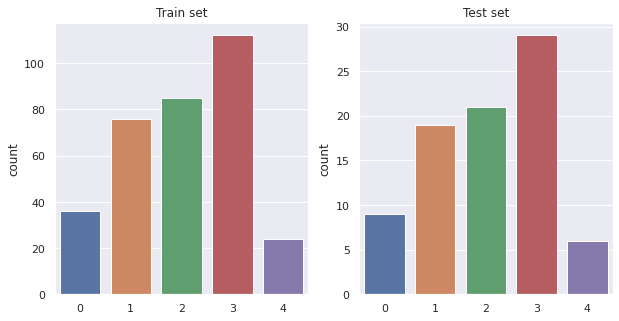

In [ ]:
# Distribution of the target variable in the train and test datasets

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.set_theme(style="darkgrid")
sns.set_context('notebook')
sns.countplot(x=y_train, ax=ax0)
ax0.set(title='Train set')
sns.countplot(x=y_test, ax=ax1)
ax1.set(title='Test set')
plt.show()

<em><strong>Observation:</strong></em>
Upon comparing the above 2 plots, it can be observed that the distribution of the target variable is the same for both the train and test datasets.


<h5 style="color:indianred"><strong><em><ins>Vectorization:</ins></em></strong></h5>

In [ ]:
# 1. Vectorizing the data using BOW - Count vectorizer. 

count_vectorizer = CountVectorizer(ngram_range=(1,2), strip_accents='ascii')
X_train_bow = count_vectorizer.fit_transform(X_train) 
X_test_bow  = count_vectorizer.transform(X_test)

In [ ]:
print(f'Length of the vocabulary generated using CountVectorizer: {len(count_vectorizer.vocabulary_)}')

Length of the vocabulary generated using CountVectorizer: 10138


In [ ]:
# A Few of the unigrams and bigrams generated 

count_vectorizer.get_feature_names_out()[:20]

array(['abb', 'abb furnace', 'abdomen', 'abdomen left', 'able',
       'able position', 'able remove', 'abrupt', 'abrupt contact',
       'abrupt movement', 'abruptly', 'abruptly drop',
       'abruptly imprison', 'abruptly withdraw', 'absorb', 'absorb small',
       'absorbent', 'absorbent cloth', 'abutment', 'abutment said'],
      dtype=object)

In [ ]:
display(X_train_bow.shape, X_test_bow.shape)

(333, 10138)

(84, 10138)

In [ ]:
# Printing the first 20 words in the BOW vocabulary dictionary

{idx: word for word, idx in count_vectorizer.vocabulary_.items() if idx<=20}

{20: 'acc',
 18: 'abutment',
 19: 'abutment said',
 4: 'able',
 6: 'able remove',
 7: 'abrupt',
 9: 'abrupt movement',
 0: 'abb',
 1: 'abb furnace',
 10: 'abruptly',
 11: 'abruptly drop',
 8: 'abrupt contact',
 12: 'abruptly imprison',
 13: 'abruptly withdraw',
 2: 'abdomen',
 3: 'abdomen left',
 5: 'able position',
 14: 'absorb',
 15: 'absorb small',
 16: 'absorbent',
 17: 'absorbent cloth'}

In [ ]:
# Converting the bow vectors to a dataframe 

X_train_bow_df = pd.DataFrame(X_train_bow.toarray(), 
                                                columns=count_vectorizer.get_feature_names_out())

In [ ]:
# Top 10 frequently occurring words in BOW

X_train_bow_df.sum().sort_values(ascending=False).head(10)

cause       157
hand        146
employee    138
right       125
left        115
operator    101
time         96
activity     91
injury       89
moment       82
dtype: int64

In [ ]:
# 2. Vectorizing the data using TF-IDF Vectorizer

tfidf = TfidfVectorizer(strip_accents='ascii')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

In [ ]:
display(X_train_tfidf.shape, X_test_tfidf.shape)

(333, 2103)

(84, 2103)

In [ ]:
print(f'Length of the vocabulary generated using tfidf: {len(tfidf.vocabulary_)}')

Length of the vocabulary generated using tfidf: 2103


In [ ]:
# A Few of the vocabulary generated 

tfidf.get_feature_names_out()[:20]

array(['abb', 'abdomen', 'able', 'abrupt', 'abruptly', 'absorb',
       'absorbent', 'abutment', 'acc', 'access', 'accessory', 'accident',
       'accidentally', 'accidently', 'accommodate', 'accompany', 'accord',
       'accretion', 'accumulate', 'accumulation'], dtype=object)

In [ ]:
# Converting the tf-idf vectors to a dataframe 

X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), 
                                                columns=tfidf.get_feature_names_out())
X_train_tfidf_df.shape

(333, 2103)

In [ ]:
# Calculate tfidf for all the columns and list the top 10 

X_train_tfidf_df.mean().sort_values(ascending=False).head(10)

employee    0.039216
hand        0.035114
cause       0.034552
right       0.031722
left        0.029365
operator    0.027163
activity    0.026310
hit         0.026151
injury      0.023774
time        0.023719
dtype: float64

<h4 style="color:indianred"><em>5. <ins>Design train and test basic machine learning classifiers:</ins></em></h4>

In [ ]:
# Function to calculate the accuracy of the model with BOW and TFIDF vectors

def model_accuracy(model):
    """Returns the Accuracy of the model with BOW and TFIDF vectors.

    Args:
        model (ML model): Machine Learning model.

    Returns:
        (tuple): Accuracy of the model with BOW and TFIDF vectors
    """
    # With BOW vectors
    model.fit(X_train_bow, y_train)
    y_pred_bow = model.predict(X_test_bow)
    acc_bow = round(accuracy_score(y_test, y_pred_bow)*100, 2)

    # With TFIDF vectors
    model.fit(X_train_tfidf, y_train)
    y_pred_tfidf = model.predict(X_test_tfidf)
    acc_tfidf = round(accuracy_score(y_test, y_pred_tfidf)*100, 2)

    return (acc_bow, acc_tfidf)

In [ ]:
# Dataframe to store the accuracy of the ML models
    
model_accuracy_df = pd.DataFrame()

In [ ]:
# Multinomial Naive Bayes

(acc_bow_mNB, acc_tfidf_mNB) = model_accuracy(MultinomialNB())
model_accuracy_df = model_accuracy_df.append(pd.DataFrame(['MultinomialNB', acc_bow_mNB, acc_tfidf_mNB]).T, ignore_index=True)

print(f'Test Accuracy (BOW): {acc_bow_mNB} %')
print(f'Test Accuracy (TFIDF): {acc_tfidf_mNB} %')

Test Accuracy (BOW): 44.05 %
Test Accuracy (TFIDF): 44.05 %


In [ ]:
# SVM

(acc_bow_svm, acc_tfidf_svm) = model_accuracy(SVC(C=1, kernel='linear', gamma=0.1))
model_accuracy_df = model_accuracy_df.append(pd.DataFrame(['SVC', acc_bow_svm, acc_tfidf_svm]).T, ignore_index=True)

print(f'Test Accuracy (BOW): {acc_bow_svm} %')
print(f'Test Accuracy (TFIDF): {acc_tfidf_svm} %')

Test Accuracy (BOW): 44.05 %
Test Accuracy (TFIDF): 45.24 %


In [ ]:
#  Linear Support Vector Machine (SGD)

(acc_bow_sgd, acc_tfidf_sgd) = model_accuracy(SGDClassifier())
model_accuracy_df = model_accuracy_df.append(pd.DataFrame(['SGDClassifier', acc_bow_sgd, acc_tfidf_sgd]).T, ignore_index=True)

print(f'Test Accuracy (BOW): {acc_bow_sgd} %')
print(f'Test Accuracy (TFIDF): {acc_tfidf_sgd} %')

Test Accuracy (BOW): 40.48 %
Test Accuracy (TFIDF): 42.86 %


In [ ]:
# Performance of ML models

model_accuracy_df.columns = ['Model', 'Accuracy with BOW', 'Accuracy with TFIDF']
model_accuracy_df

,Model,Accuracy with BOW,Accuracy with TFIDF
0,MultinomialNB,44.05,44.05
1,SVC,44.05,45.24
2,SGDClassifier,40.48,42.86


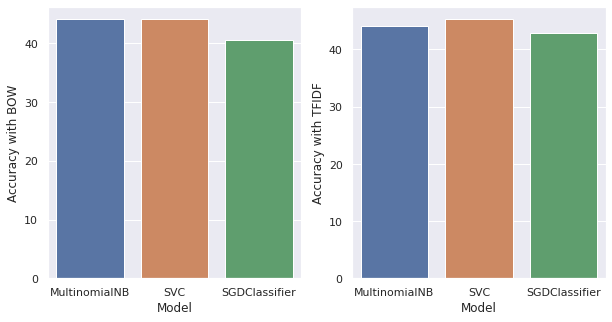

In [ ]:
# Performance plots

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.set_theme(style="darkgrid")
sns.set_context('notebook')
sns.barplot(data=model_accuracy_df, x='Model', y='Accuracy with BOW', ax=ax0)
sns.barplot(data=model_accuracy_df, x='Model', y='Accuracy with TFIDF', ax=ax1)
plt.show()

<h5 style="color:indianred"><strong>5.1 <em><ins>Hyperparameter Tuning:</ins></em></strong></h5>

In [ ]:
# SVM - hyperparameter tuning using Grid Search Cross Validation

param_grid = {'C':[0.1, 1], 'gamma':[0.0001, 0.001, 0.01, 0.1]}
svm = SVC(kernel='linear')
svm_cv = GridSearchCV(svm, param_grid, scoring='accuracy') 
svm_cv.fit(X_train_tfidf, y_train)
print(f'Best params: {svm_cv.best_params_}')
print(f'Best score: {svm_cv.best_score_}')
print(f'Test accuracy using the best hyperparameters: {svm_cv.score(X_test_tfidf, y_test)}')

Best params: {'C': 1, 'gamma': 0.0001}
Best score: 0.39023066485753055
Test accuracy using the best hyperparameters: 0.4523809523809524


In [ ]:
# Linear Support Vector Machine (SGD) - hyperparameter tuning using Grid Search Cross Validation

param_grid = {'penalty':['l1', 'l2', 'elasticnet'], 'loss':['hinge', 'squared_hinge']}
sgd = SGDClassifier()
sgd_cv = GridSearchCV(sgd, param_grid, scoring='accuracy') 
sgd_cv.fit(X_train_tfidf, y_train)
print(f'Best params: {sgd_cv.best_params_}')
print(f'Best score: {sgd_cv.best_score_}')
print(f'Test accuracy using the best hyperparameters: {sgd_cv.score(X_test_tfidf, y_test)}')

Best params: {'loss': 'hinge', 'penalty': 'l2'}
Best score: 0.4293532338308458
Test accuracy using the best hyperparameters: 0.4166666666666667


In [ ]:
# Multinomial Naive Bayes - hyperparameter tuning using Grid Search Cross Validation

param_grid = {'alpha':[1.0, 0.9, 0.8]}
mNB = MultinomialNB()
mNB_cv = GridSearchCV(mNB, param_grid, scoring='accuracy') 
mNB_cv.fit(X_train_tfidf, y_train)
print(f'Best params: {mNB_cv.best_params_}')
print(f'Best score: {mNB_cv.best_score_}')
print(f'Test accuracy using the best hyperparameters: {mNB_cv.score(X_test_tfidf, y_test)}')

Best params: {'alpha': 0.9}
Best score: 0.38127544097693356
Test accuracy using the best hyperparameters: 0.44047619047619047


In [ ]:
# Best ML Model after hyperparameter tuning -  SVM with 'C'=1 and 'gamma'=0.0001 

model_best = SVC(kernel='linear', C=1, gamma=0.0001)

In [ ]:
# Function to print performance metrics on the test data set

def perf_metrics(y_test, y_pred):
    """Print performance metrics on the test data set
    
    Args:    
        y_test(list): The actual labels.
        y_pred(list): The predicted labels.
    """
    
    print(f'Classification Report:\n {classification_report(y_test, y_pred, digits=2)}')
    print(f'Accuracy: {round(accuracy_score(y_test, y_pred),4)}')

In [ ]:
# With BOW vectors

model_best.fit(X_train_bow, y_train)
y_pred_bow = model_best.predict(X_test_bow)
    
perf_metrics(y_test, y_pred_bow)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.41      0.47      0.44        19
           2       0.25      0.38      0.30        21
           3       0.58      0.48      0.53        29
           4       1.00      0.17      0.29         6

    accuracy                           0.44        84
   macro avg       0.65      0.41      0.45        84
weighted avg       0.53      0.44      0.45        84

Accuracy: 0.4405


In [ ]:
# With TFIDF vectors

model_best.fit(X_train_tfidf, y_train)
y_pred_tfidf = model_best.predict(X_test_tfidf)

perf_metrics(y_test, y_pred_tfidf)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.38      0.32      0.34        19
           2       0.33      0.33      0.33        21
           3       0.46      0.66      0.54        29
           4       1.00      0.17      0.29         6

    accuracy                           0.45        84
   macro avg       0.63      0.41      0.44        84
weighted avg       0.51      0.45      0.45        84

Accuracy: 0.4524


<ins><strong>Conclusion:</strong></ins>

After tuning the hyperparameters of the models using Grid Search cross validation, SVM model with 'linear' kernel and with  'C'=1 and 'gamma'=0.0001 has given the best performance of 45.24% when trained with TF-IDF vectors.

Since, linear models have been widely regarded as one of the best text classification ML algorithms, opting for a 'linear' kernel has made SVM perform better than the other algorithms.

In general, since ML models are quite weak for NLP tasks when compared to the other state-of-the-art DL models, the performance has not been that great. Also, since the dataset is very small, the models could not be trained sufficiently even after hyperparameter tuning. Hence, ‘Target variable balancing’ using ‘Text Augmentation’ was considered for improving the performance of the ML models.

However, among the ML models used for training the given dataset, SVM with a linear kernel, has outperformed the other models after hyperparameter tuning.

<h5 style="color:indianred"><strong>5.2 <em><ins>Target Balancing using nlpaug:</ins></em></strong></h5>

In [ ]:
indus_safety_cleaned['Potential Accident Level'].value_counts()

IV     141
III    106
II      95
I       45
V       30
Name: Potential Accident Level, dtype: int64

In [ ]:
# Separating the majority and minority classes

majority = indus_safety_cleaned[indus_safety_cleaned['Potential Accident Level'] == 'IV']
minority1 = indus_safety_cleaned[indus_safety_cleaned['Potential Accident Level'] == 'III']
minority2 = indus_safety_cleaned[indus_safety_cleaned['Potential Accident Level'] == 'II']
minority3 = indus_safety_cleaned[indus_safety_cleaned['Potential Accident Level'] == 'I']
minority4 = indus_safety_cleaned[indus_safety_cleaned['Potential Accident Level'] == 'V']

In [ ]:
# Synonym Augmention with nlpaug using 'wordnet'

aug = naw.SynonymAug(aug_src='wordnet', aug_max=6)

# Synonym Augmention for minority classes
minority1_aug = aug.augment(minority1['Preprocessed Description'].head(35).tolist())
minority1_labels = ['III'] * 35
minority1_aug_df = pd.DataFrame([minority1_aug, minority1_labels]).T
minority1_aug_df.columns = ['Preprocessed Description', 'Potential Accident Level']

minority2_aug = aug.augment(minority2['Preprocessed Description'].head(46).tolist())
minority2_labels = ['II'] * 46
minority2_aug_df = pd.DataFrame([minority2_aug, minority2_labels]).T
minority2_aug_df.columns = ['Preprocessed Description', 'Potential Accident Level']

minority3_aug = aug.augment(minority3['Preprocessed Description'].tolist())
minority3_aug_1 = aug.augment(minority3['Preprocessed Description'].tolist())
minority3_aug_2 = aug.augment(minority3['Preprocessed Description'].head(6).tolist())
[minority3_aug.extend(lists) for lists in (minority3_aug_1, minority3_aug_2)]
minority3_labels = ['I'] * 96
minority3_aug_df = pd.DataFrame([minority3_aug, minority3_labels]).T
minority3_aug_df.columns = ['Preprocessed Description', 'Potential Accident Level']

minority4_aug = aug.augment(minority4['Preprocessed Description'].tolist())
minority4_aug_1 = aug.augment(minority4['Preprocessed Description'].tolist())
minority4_aug_2 = aug.augment(minority4['Preprocessed Description'].tolist())
minority4_aug_3 = aug.augment(minority4['Preprocessed Description'].head(21).tolist())
[minority4_aug.extend(lists) for lists in (minority4_aug_1, minority4_aug_2, minority4_aug_3)]
minority4_labels = ['V'] * 111
minority4_aug_df = pd.DataFrame([minority4_aug, minority4_labels]).T
minority4_aug_df.columns = ['Preprocessed Description', 'Potential Accident Level']

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Augmented Dataset

indus_safety_augmented = pd.concat([indus_safety_cleaned, minority1_aug_df, minority2_aug_df, minority3_aug_df, minority4_aug_df], ignore_index=True)

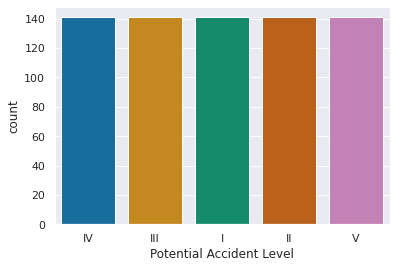

In [ ]:
# Checking the distribution of the target variable - 'Potential Accident Level' - after text augmentation

sns.set_theme(style="darkgrid")
sns.set_context('notebook')
sns.countplot(data=indus_safety_augmented,
                            x='Potential Accident Level', 
                            palette='colorblind')
plt.show()

In [ ]:
indus_safety_augmented['Potential Accident Level'].value_counts()

IV     141
III    141
I      141
II     141
V      141
Name: Potential Accident Level, dtype: int64

In [ ]:
# Saving the augmented dataset in a .csv file for Milestone-2

indus_safety_augmented[["Preprocessed Description", "Potential Accident Level"]].to_csv('/content/drive/MyDrive/AIML/Capstone/indus_safety_augmented.csv', index=False)


In [ ]:
# Creating dependent and independent variables with the augmented Dataset

X_aug = indus_safety_augmented['Preprocessed Description']
y_aug = indus_safety_augmented['Potential Accident Level']

In [ ]:
# Label Encoding the target variable

y_enc_aug = y_aug.astype('category').cat.codes.values

In [ ]:
# Splitting the augmented data into train and test

X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_aug, y_enc_aug, test_size=0.20, random_state=42, stratify=y_enc_aug)

In [ ]:
display(X_train_aug.shape, X_test_aug.shape, y_train_aug.shape, y_test_aug.shape)

(564,)

(141,)

(564,)

(141,)

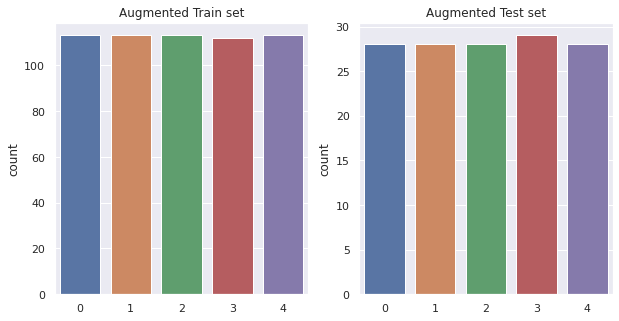

In [ ]:
# Distribution of the target variable in the train and test datasets

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.set_theme(style="darkgrid")
sns.set_context('notebook')
sns.countplot(x=y_train_aug, ax=ax0)
ax0.set(title='Augmented Train set')
sns.countplot(x=y_test_aug, ax=ax1)
ax1.set(title='Augmented Test set')
plt.show()

In [ ]:
# 1. Vectorizing the data using BOW - Count vectorizer. 

count_vectorizer = CountVectorizer(ngram_range=(1,2), strip_accents='ascii')
X_train_aug_bow = count_vectorizer.fit_transform(X_train_aug) 
X_test_aug_bow  = count_vectorizer.transform(X_test_aug)

In [ ]:
# 2. Vectorizing the data using TF-IDF Vectorizer

tfidf = TfidfVectorizer(strip_accents='ascii')
X_train_aug_tfidf = tfidf.fit_transform(X_train_aug)
X_test_aug_tfidf  = tfidf.transform(X_test_aug)

In [ ]:
# Function to calculate the accuracy of the model with BOW and TFIDF vectors with Augmented text

def aug_model_accuracy(model):
    """Returns the Accuracy of the model with BOW and TFIDF vectors with Augmented text 

    Args:
        model (ML model): Machine Learning model.

    Returns:
        (tuple): Accuracy of the model with BOW and TFIDF vectors
    """
    # With BOW vectors
    model.fit(X_train_aug_bow, y_train_aug)
    y_pred_aug_bow = model.predict(X_test_aug_bow)
    acc_aug_bow = round(accuracy_score(y_test_aug, y_pred_aug_bow)*100, 2)

    # With TFIDF vectors
    model.fit(X_train_aug_tfidf, y_train_aug)
    y_pred_aug_tfidf = model.predict(X_test_aug_tfidf)
    acc_aug_tfidf = round(accuracy_score(y_test_aug, y_pred_aug_tfidf)*100, 2)

    return (acc_aug_bow, acc_aug_tfidf)

In [ ]:
# Dataframe to store the accuracy of the ML models with augmented text data
    
aug_model_accuracy_df = pd.DataFrame()

In [ ]:
# Multinomial Naive Bayes with augmented text data

(acc_bow_mNB, acc_tfidf_mNB) = aug_model_accuracy(MultinomialNB(alpha=0.9))
aug_model_accuracy_df = aug_model_accuracy_df.append(pd.DataFrame(['MultinomialNB', acc_bow_mNB, acc_tfidf_mNB]).T, ignore_index=True)

print(f'Test Accuracy (BOW): {acc_bow_mNB} %')
print(f'Test Accuracy (TFIDF): {acc_tfidf_mNB} %')

Test Accuracy (BOW): 78.01 %
Test Accuracy (TFIDF): 72.34 %


In [ ]:
# SVM with augmented text data

(acc_bow_svm, acc_tfidf_svm) = aug_model_accuracy(SVC(C=1, kernel='linear', gamma=0.0001))
aug_model_accuracy_df = aug_model_accuracy_df.append(pd.DataFrame(['SVC', acc_bow_svm, acc_tfidf_svm]).T, ignore_index=True)

print(f'Test Accuracy (BOW): {acc_bow_svm} %')
print(f'Test Accuracy (TFIDF): {acc_tfidf_svm} %')

Test Accuracy (BOW): 74.47 %
Test Accuracy (TFIDF): 75.89 %


In [ ]:
#  Linear Support Vector Machine (SGD) with augmented text data

(acc_bow_sgd, acc_tfidf_sgd) = aug_model_accuracy(SGDClassifier(loss='hinge', penalty='l2'))
aug_model_accuracy_df = aug_model_accuracy_df.append(pd.DataFrame(['SGDClassifier', acc_bow_sgd, acc_tfidf_sgd]).T, ignore_index=True)

print(f'Test Accuracy (BOW): {acc_bow_sgd} %')
print(f'Test Accuracy (TFIDF): {acc_tfidf_sgd} %')

Test Accuracy (BOW): 71.63 %
Test Accuracy (TFIDF): 75.18 %


In [ ]:
# Performance of ML models with Augmented data

aug_model_accuracy_df.columns = ['Model', 'Accuracy with BOW', 'Accuracy with TFIDF']
aug_model_accuracy_df

,Model,Accuracy with BOW,Accuracy with TFIDF
0,MultinomialNB,78.01,72.34
1,SVC,74.47,75.89
2,SGDClassifier,71.63,75.18


In [ ]:
# Best ML Model after text augmentation - with BOW vectors 

model_best_aug_bow = MultinomialNB(alpha=0.9)
model_best_aug_bow.fit(X_train_aug_bow, y_train_aug)
y_pred_bow = model_best_aug_bow.predict(X_test_aug_bow)
    
perf_metrics(y_test_aug, y_pred_bow)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88        28
           1       0.85      0.39      0.54        28
           2       0.76      0.68      0.72        28
           3       0.65      0.83      0.73        29
           4       0.93      1.00      0.97        28

    accuracy                           0.78       141
   macro avg       0.79      0.78      0.76       141
weighted avg       0.79      0.78      0.76       141

Accuracy: 0.7801


In [ ]:
# Best ML Model after text augmentation - with tfidf vectors 

model_best_aug_tfidf = SVC(C=1, kernel='linear', gamma=0.0001)
model_best_aug_tfidf.fit(X_train_aug_tfidf, y_train_aug)
y_pred_tfidf = model_best_aug_tfidf.predict(X_test_aug_tfidf)
    
perf_metrics(y_test_aug, y_pred_tfidf)

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       0.67      0.50      0.57        28
           2       0.64      0.64      0.64        28
           3       0.65      0.76      0.70        29
           4       0.96      0.93      0.95        28

    accuracy                           0.76       141
   macro avg       0.76      0.76      0.75       141
weighted avg       0.76      0.76      0.75       141

Accuracy: 0.7589


<ins><strong>Conclusion:</strong></ins>

After balancing the target using text augmentation with 'nlpaug' library, there has been a tremendous improvement in the performance of the ML models. 

With BOW vectors, 'Multinomial Naive Bayes' has given the best performance of 78%. This is a significant improvement over 44.05% after hyperparameter tuning.

With TFIDF vectors, 'SVM with a linear kernel' has given the best performance of 76%. Again, this is also a significant improvement over 45.24% after hyperparameter tuning.

In general, ML models are quite weak for NLP tasks when compared to the other state-of-the-art DL models. Also, since the dataset was initially very small, the models could not be trained sufficiently. However, after synonym augmentation using the 'nlpaug' library for balancing the target, the performance of the models improved tremendously.

### Milestone 2:
***

In [ ]:
# Installing tranformers for BERT contextual embeddings

!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 119.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.0 MB/s eta 0:00:00


In [ ]:
# Importing the preprocessed and balanced dataset from Milestone-1 

indus_safety_preprocessed = pd.read_csv('/content/drive/MyDrive/AIML/Capstone/indus_safety_augmented.csv')
indus_safety_preprocessed.head()

,Preprocessed Description,Potential Accident Level
0,remove drill rod jumbo maintenance supervisor ...,IV
1,activation sodium sulphide pump piping uncoupl...,IV
2,sub station milpo locate level collaborator ex...,III
3,approximately nv personnel begin task unlock s...,I
4,approximately circumstance mechanic anthony gr...,IV


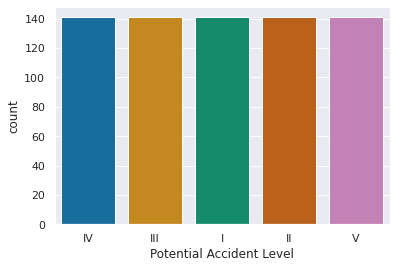

In [ ]:
# Checking the distribution of the target variable - 'Potential Accident Level'

sns.set_theme(style="darkgrid")
sns.set_context('notebook')
sns.countplot(data=indus_safety_preprocessed,
                     x='Potential Accident Level', 
                     palette='colorblind')
plt.show()

As the dataset is already preprocessed and balanced in Milestone-1, it is evident that the target variable in the above plot is well balanced.

<h5 style="color:indianred"><strong><em><ins>Text preprocessing for Sequential models:</ins></em></strong></h5>

In [ ]:
# Creating column 'seq_len' to store the length of each sentence

indus_safety_preprocessed['seq_len'] = [len(txt.split()) for txt in indus_safety_preprocessed['Preprocessed Description']]

In [ ]:
indus_safety_preprocessed.head()

,Preprocessed Description,Potential Accident Level,seq_len
0,remove drill rod jumbo maintenance supervisor ...,IV,35
1,activation sodium sulphide pump piping uncoupl...,IV,26
2,sub station milpo locate level collaborator ex...,III,28
3,approximately nv personnel begin task unlock s...,I,47
4,approximately circumstance mechanic anthony gr...,IV,42


In [ ]:
indus_safety_preprocessed.seq_len.describe()

count    705.000000
mean      32.295035
std       14.737795
min        8.000000
25%       21.000000
50%       30.000000
75%       40.000000
max       87.000000
Name: seq_len, dtype: float64

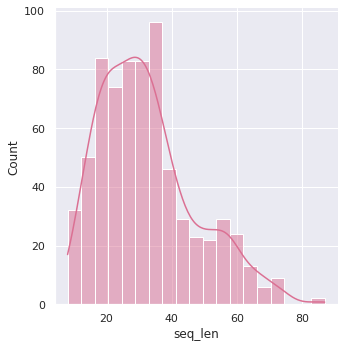

In [ ]:
# Distribution of seq length

sns.set_style('darkgrid')
sns.set_context('notebook')
sns.displot(indus_safety_preprocessed.seq_len, kde=True, color='palevioletred')
plt.show()

<em><strong>Insight:</strong></em>
The Distribution is slightly skewed on the right and the median sequence length of the sentences seems to be around 30 words.

In [ ]:
# Defining the parameters

# Maximum sequence length of each sentence
max_seq_len = 30

# Vocabulary size
max_features = 3000 

# Dimension of the word vector
embedding_dim = 50

In [ ]:
# Building the dictionary of indices

description_text = indus_safety_preprocessed['Preprocessed Description']

text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(description_text)

In [ ]:
# Changing  texts into sequence of indexes

description_idx = text_tokenizer.texts_to_sequences(description_text)

In [ ]:
np.array(description_idx[6])

array([  17,   91,  972, 1879,    7,    3,  973,  974,   70,   33,    3,
         99,  973,  974,   72, 1880,    2,  100,  164,    7,    3])

In [ ]:
# Padding the sequences to make all the sequences have the same lengths

description_idx = pad_sequences(description_idx, max_seq_len, padding='post', truncating='post')

In [ ]:
description_idx[6]

array([  17,   91,  972, 1879,    7,    3,  973,  974,   70,   33,    3,
         99,  973,  974,   72, 1880,    2,  100,  164,    7,    3,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
# Splitting the data into features X and labels y

X = description_idx
y = indus_safety_preprocessed['Potential Accident Level']

In [ ]:
# Label Encoding the target variable

y_enc = y.astype('category').cat.codes.values

In [ ]:
# Splitting the data into train & test with 80:20 proportion

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.20, stratify=y_enc, random_state=42)

In [ ]:
# Shape of the train and test variables

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(564, 30)
(141, 30)
(564,)
(141,)


In [ ]:
# Getting the original vocabulary size

vocab_size = len(text_tokenizer.word_index)
print(f'vocabulary size: {vocab_size}')

vocabulary size: 3003


In [ ]:
# Printing the 50 most frequent words in the vocabulary dictionary

{idx: word for idx, word in text_tokenizer.index_word.items() if idx<=50}

{1: 'employee',
 2: 'cause',
 3: 'hand',
 4: 'right',
 5: 'operator',
 6: 'activity',
 7: 'left',
 8: 'injury',
 9: 'time',
 10: 'work',
 11: 'use',
 12: 'moment',
 13: 'equipment',
 14: 'worker',
 15: 'hit',
 16: 'area',
 17: 'collaborator',
 18: 'perform',
 19: 'fall',
 20: 'accident',
 21: 'team',
 22: 'level',
 23: 'pipe',
 24: 'rock',
 25: 'assistant',
 26: 'finger',
 27: 'remove',
 28: 'leave',
 29: 'meter',
 30: 'cm',
 31: 'mr',
 32: 'mesh',
 33: 'place',
 34: 'm',
 35: 'floor',
 36: 'safety',
 37: 'support',
 38: 'height',
 39: 'approximately',
 40: 'cut',
 41: 'truck',
 42: 'glove',
 43: 'pump',
 44: 'come',
 45: 'kg',
 46: 'impact',
 47: 'circumstance',
 48: 'face',
 49: 'return',
 50: 'carry'}

In [ ]:
# Path of the GloVe embeddings

path ='/content/drive/MyDrive/AIML/Capstone/glove.6B/glove.6B.50d.txt' 

In [ ]:
# Function to get the GloVE embeddings

def get_glove_vectors(path):
    """Return the dictionary of pre-trained global vectors
    
    Args:    
        path (str): The path of the GloVe embeddings textfile.

    Returns:    
        glove_vector_dict (dict): The dictionary containing words with their global vectors
    """
    # Dictionary to store the GloVe word embeddings 
    glove_vector_dict = {}

    with open(path) as f:
        for line in f:            
            values = line.split()            
            word = values[0]            
            vector = values[1:]            
            glove_vector_dict[word] = np.asarray(vector, dtype='float32')
            
    return glove_vector_dict

In [ ]:
# Extracting the dictionary of GloVe vectors

glove_vectors_dict = get_glove_vectors(path)

In [ ]:
# Displaying a few glove vectors

glove_vectors_df = pd.DataFrame(glove_vectors_dict).T
glove_vectors_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
chanty,0.232040,0.025672,-0.70699,-0.045465,0.13989,-0.628070,0.726250,0.341080,0.446140,0.163290,...,-0.095526,-0.29605,0.385670,0.136840,0.593310,-0.694860,0.124100,-0.18069,-0.258300,-0.039673
kronik,-0.609210,-0.672180,0.23521,-0.111950,-0.46094,-0.007462,0.255780,0.856320,0.055977,-0.237920,...,0.672050,-0.59822,-0.202590,0.392430,0.028873,0.030003,-0.106170,-0.11411,-0.249010,-0.120260
rolonda,-0.511810,0.058706,1.09130,-0.551630,-0.10249,-0.126500,0.995030,0.079711,-0.162460,0.564880,...,0.024747,0.20092,-1.085100,-0.136260,0.350520,-0.858910,0.067858,-0.25003,-1.125000,1.586300
zsombor,-0.758980,-0.474260,0.47370,0.772500,-0.78064,0.232330,0.046114,0.840140,0.243710,0.022978,...,0.454390,-0.84254,0.106500,-0.059397,0.090449,0.305810,-0.614240,0.78954,-0.014116,0.644800
sandberger,0.072617,-0.513930,0.47280,-0.522020,-0.35534,0.346290,0.232110,0.230960,0.266940,0.410280,...,0.688800,-0.17986,-0.066569,-0.480440,-0.559460,-0.275940,0.056072,-0.18907,-0.590210,0.555590


In [ ]:
# Function to extract glove vectors for the given vocabulary

def filter_glove_words(vocabulary_dict, glove_vectors_dict, embedding_dim=50):
    """Extract the glove vectors for the given vocabulary
    
    Args:    
        vocabulary_dict (dict): The vocabulary set.
        glove_vectors_dict (dict): The glove words with their embeddings
        embedding_dim (int): The dimension of the embeddings

    Returns:    
        embedding_matrix (numpy array): The matrix containing the embeddings for the vocabulary
    """
    # Creating a matrix to store the vectors    
    embedding_matrix = np.zeros((len(vocabulary_dict)+1, embedding_dim))

    for i, word in vocabulary_dict.items():    
        embedding_vector = glove_vectors_dict.get(word)
        
        if embedding_vector is not None:
            # Words not found in the glove_vectors_dict will be all-zeros.        
            embedding_matrix[i] = embedding_vector
        
    return embedding_matrix

In [ ]:
# Extracting the Weight matrix using GloVe embeddings for the given vocabulary

text_embedding_matrix = filter_glove_words(text_tokenizer.index_word, glove_vectors_dict, embedding_dim)

In [ ]:
len(text_embedding_matrix)

3004

<h4 style="color:indianred"><em>1. <ins>Design, train and test Neural networks classifiers:</ins></em></h4>

In [ ]:
# Dataframe to store the accuracy of the DL models
    
model_accuracy_df = pd.DataFrame()

In [ ]:
# Function that creates a Neural Network classifier 

def create_NN_model(learning_rate=0.001, alpha_lr=0.6, vocab_dim=vocab_size, embeddings=text_embedding_matrix):
    """Create an Neural Network classifier model 
    
    Args:    
        learning_rate(float): The learning rate of the model.
        alpha_lr(float): Negative slope coefficient of Leaky ReLU
        vocab_dim(int): The vocabulary size of the dataset
        embeddings(numpy array): The embeddings initializer matrix 

    Returns:    
        model_NN(model): The compiled NN model
    """
    
    # Creating an NN classification model 
    model_NN = Sequential()

    # Embedding layer
    model_NN.add(Embedding(input_dim=vocab_dim+1,
                                            output_dim=embedding_dim,
                                            trainable=False,
                                            embeddings_initializer=Constant(embeddings),
                                            input_length=max_seq_len,
                                            name="Embedding"))

    # Input and Hidden Layers
    model_NN.add(SpatialDropout1D(rate=0.3))
    # Flattening out the sequence 
    model_NN.add(Flatten())  
    model_NN.add(Dense(embedding_dim, activation='relu'))
    model_NN.add(Dense(64, kernel_initializer='uniform'))
    model_NN.add(BatchNormalization())
    model_NN.add(LeakyReLU(alpha=alpha_lr))
    model_NN.add(Dropout(0.5))

    model_NN.add(Dense(32, kernel_initializer='uniform'))
    model_NN.add(BatchNormalization())
    model_NN.add(LeakyReLU(alpha=alpha_lr))
    model_NN.add(Dropout(0.5))
    
    model_NN.add(Dense(16, kernel_initializer='uniform'))
    model_NN.add(BatchNormalization())
    model_NN.add(LeakyReLU(alpha=alpha_lr))
    model_NN.add(Dropout(0.7))
    
    # Output layer
    model_NN.add(Dense(5, activation='softmax', kernel_initializer='uniform'))

    # Compiling the model
    adam = optimizers.Adam(learning_rate=learning_rate)
    model_NN.compile(loss='sparse_categorical_crossentropy', 
                                optimizer=adam, 
                                metrics=['accuracy'])

    return model_NN

In [ ]:
# Designing a Neural Network classifier

model_NN = create_NN_model(learning_rate=0.01, alpha_lr=0.6, vocab_dim=vocab_size, embeddings=text_embedding_matrix )
model_NN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 30, 50)            150200    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 30, 50)           0         
 lDropout1D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 50)                75050     
                                                                 
 dense_6 (Dense)             (None, 64)                3264      
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                      

In [ ]:
# Function that returns the callbacks to be used in the model

def model_callbacks():
    """Returns the callbacks to be used in the model
    
    Returns:    
        (list): List of callbacks 
    """
    monitor_val_acc = EarlyStopping(monitor='val_loss', patience=50)
    model_Checkpoint = ModelCheckpoint('best_model.hdf5', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, min_lr=0.00001, mode='auto')

    return [model_Checkpoint, reduce_lr, monitor_val_acc]

In [ ]:
# Training the Neural Network classifier

h_callback = model_NN.fit(X_train,
                                        y_train, 
                                        epochs=100,
                                        batch_size=128,
                                        validation_data=(X_test, y_test),
                                        callbacks=model_callbacks())

Epoch 1/100
5/5 [==============================] - 2s 74ms/step - loss: 1.6200 - accuracy: 0.2004 - val_loss: 1.6081 - val_accuracy: 0.2411
Epoch 2/100
5/5 [==============================] - 0s 13ms/step - loss: 1.5684 - accuracy: 0.2730 - val_loss: 1.5900 - val_accuracy: 0.3475
Epoch 3/100
5/5 [==============================] - 0s 16ms/step - loss: 1.4549 - accuracy: 0.3918 - val_loss: 1.4957 - val_accuracy: 0.3617
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 1.3351 - accuracy: 0.4823 - val_loss: 1.3186 - val_accuracy: 0.4610
Epoch 5/100
5/5 [==============================] - 0s 14ms/step - loss: 1.1964 - accuracy: 0.5230 - val_loss: 1.2961 - val_accuracy: 0.4823
Epoch 6/100
5/5 [==============================] - 0s 15ms/step - loss: 1.0803 - accuracy: 0.5709 - val_loss: 1.4442 - val_accuracy: 0.4965
Epoch 7/100
5/5 [==============================] - 0s 13ms/step - loss: 0.9682 - accuracy: 0.6223 - val_loss: 1.5645 - val_accuracy: 0.4965
Epoch 8/100
5/5 [===

In [ ]:
# Evaluating the NN model accuracy on the test data

accuracy_NN = model_NN.evaluate(X_test, y_test, verbose=0)[1]
model_accuracy_df = model_accuracy_df.append(pd.DataFrame(['Neural Network', round(accuracy_NN, 3)*100]).T, ignore_index=True)

print(f'Test accuracy: {round(accuracy_NN, 3)*100}%')

Test accuracy: 62.4%


In [ ]:
# Function to print performance metrics on the test data set

def perf_metrics(y_test, y_pred):
    """Print performance metrics on the test data set
    
    Args:    
        y_test(list): The actual labels.
        y_pred(list): The predicted labels.
    """
    
    print(f'Classification Report:\n {classification_report(y_test, y_pred, digits=2)}')
    print(f'Accuracy: {round(accuracy_score(y_test, y_pred),3)*100}%')

In [ ]:
# Evaluating the performance of the Neural Network classifier on the test data 

y_pred_prob = model_NN.predict(X_test, verbose=0)
y_pred_NN = [np.argmax(i) for i in y_pred_prob]

perf_metrics(y_test, y_pred_NN)

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.69      0.39      0.50        28
           2       0.44      0.61      0.51        28
           3       0.50      0.52      0.51        29
           4       0.77      0.82      0.79        28

    accuracy                           0.62       141
   macro avg       0.65      0.62      0.62       141
weighted avg       0.65      0.62      0.62       141

Accuracy: 62.4%


<ins><strong>Insight:</strong></ins> The Neural Network classifier has achieved an accuracy of 62.4% with a 65% precision  and a 62% of recall and F1-score, giving a good overall performance. Since the dataset is already target balanced, 'accuracy' can be taken into consideration as a performance parameter.


<h4 style="color:indianred"><em>2. <ins>Design, train and test RNN or LSTM classifiers

<h5 style="color:indianred"><strong><ins>LSTM classifier:</ins></em></strong></h5>

In [ ]:
# Function that creates an LSTM classifier

def create_LSTM_model(learning_rate=0.01, lstm_units=128, vocab_dim=vocab_size, embeddings=text_embedding_matrix):
    """Create an LSTM classifier model
    
    Args:    
        learning_rate(float): The learning rate of the model.
        lstm_units (int): The number of units in the LSTM layer

    Returns:    
        model_LSTM(model): The compiled LSTM model
    """
    
    # Creating an LSTM classification model
    model_LSTM = Sequential()

    # Embedding layer
    model_LSTM.add(Embedding(input_dim=vocab_dim+1,
                                                output_dim=embedding_dim,
                                                trainable=False,
                                                embeddings_initializer=Constant(embeddings),
                                                input_length=max_seq_len,
                                                name="Embedding"))

    # Hidden layers
    model_LSTM.add(SpatialDropout1D(rate=0.1))
    model_LSTM.add(Dense(embedding_dim, activation='relu', kernel_initializer='uniform', name="Dense1"))
    model_LSTM.add(Bidirectional(LSTM(units=lstm_units, 
                                                          return_sequences=False, 
                                                          dropout=0.4, 
                                                          recurrent_dropout=0.4, 
                                                          kernel_initializer='uniform', 
                                                          name="LSTM")))
    model_LSTM.add(Dense(32, kernel_initializer='uniform', name="Dense2"))
    model_LSTM.add(Dense(16, kernel_initializer='uniform', name="Dense3"))

    # Output layer
    model_LSTM.add(Dense(5, activation='softmax', kernel_initializer='uniform', name="Output"))

    # Compiling the Bidirectional LSTM model
    adam = optimizers.Adam(learning_rate=learning_rate)
    model_LSTM.compile(loss='sparse_categorical_crossentropy', 
                                    optimizer=adam, 
                                    metrics=['accuracy'])
    return model_LSTM

In [ ]:
# Designing an LSTM classifier

model_LSTM = create_LSTM_model(learning_rate=0.01, lstm_units=128, vocab_dim=vocab_size, embeddings=text_embedding_matrix)
model_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 30, 50)            150200    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 30, 50)           0         
 lDropout1D)                                                     
                                                                 
 Dense1 (Dense)              (None, 30, 50)            2550      
                                                                 
 bidirectional (Bidirectiona  (None, 256)              183296    
 l)                                                              
                                                                 
 Dense2 (Dense)              (None, 32)                8224      
                                                                 
 Dense3 (Dense)              (None, 16)               

In [ ]:
# Training the LSTM classifier

h_callback_LSTM = model_LSTM.fit(X_train,
                                                    y_train, 
                                                    epochs=100,
                                                    batch_size=128,
                                                    validation_data=(X_test, y_test),
                                                    callbacks=model_callbacks())

Epoch 1/100
5/5 [==============================] - 9s 522ms/step - loss: 1.6127 - accuracy: 0.2039 - val_loss: 1.6098 - val_accuracy: 0.1986
Epoch 2/100
5/5 [==============================] - 2s 361ms/step - loss: 1.6090 - accuracy: 0.2004 - val_loss: 1.5994 - val_accuracy: 0.2979
Epoch 3/100
5/5 [==============================] - 2s 359ms/step - loss: 1.6024 - accuracy: 0.3014 - val_loss: 1.5804 - val_accuracy: 0.2837
Epoch 4/100
5/5 [==============================] - 2s 357ms/step - loss: 1.5581 - accuracy: 0.2908 - val_loss: 1.5484 - val_accuracy: 0.2624
Epoch 5/100
5/5 [==============================] - 2s 353ms/step - loss: 1.5412 - accuracy: 0.3528 - val_loss: 1.5399 - val_accuracy: 0.3262
Epoch 6/100
5/5 [==============================] - 2s 443ms/step - loss: 1.5105 - accuracy: 0.3387 - val_loss: 1.5507 - val_accuracy: 0.2979
Epoch 7/100
5/5 [==============================] - 2s 467ms/step - loss: 1.5264 - accuracy: 0.3138 - val_loss: 1.5614 - val_accuracy: 0.2695
Epoch 8/100
5

In [ ]:
# Evaluating the LSTM model accuracy on the test data

accuracy_LSTM = model_LSTM.evaluate(X_test, y_test, verbose=0)[1]
model_accuracy_df = model_accuracy_df.append(pd.DataFrame(['LSTM', round(accuracy_LSTM, 3)*100]).T, ignore_index=True)

print(f'Test accuracy: {round(accuracy_LSTM, 2)*100}%')

Test accuracy: 66.0%


In [ ]:
# Evaluating the performance of the Neural Network classifier on the test data 

y_pred_prob = model_LSTM.predict(X_test, verbose=0)
y_pred_LSTM = [np.argmax(i) for i in y_pred_prob]

perf_metrics(y_test, y_pred_LSTM)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85        28
           1       0.50      0.32      0.39        28
           2       0.56      0.64      0.60        28
           3       0.61      0.48      0.54        29
           4       0.73      0.96      0.83        28

    accuracy                           0.66       141
   macro avg       0.64      0.66      0.64       141
weighted avg       0.64      0.66      0.64       141

Accuracy: 66.0%


<ins><strong>Insight:</strong></ins> The LSTM classifier has achieved an accuracy of 66%, with a 66% recall  and a 64% of precision and F1-score. The accuracy, recall and F1-scores  are higher than the NN model. However, the precision has decreased to 64%. 

<h5 style="color:indianred"><strong><ins>CNN - LSTM classifier:</ins></em></strong></h5>

In [ ]:
# Function that creates a classifier model with CNN and LSTM

def create_CNN_model(learning_rate=0.01, lstm_units=128, vocab_dim=vocab_size, embeddings=text_embedding_matrix):
    """Create a classifier model with CNN and LSTM
    
    Args:    
        learning_rate (float): The learning rate of the model.
        lstm_units (int): The number of units in the LSTM layer

    Returns:    
        model_CNN(model): The compiled model
    """
    
    # Creating a CNN - LSTM classification model 
    model_CNN = Sequential()

    # Embedding layer
    model_CNN.add(Embedding(input_dim=vocab_dim+1,
                                              output_dim=embedding_dim,
                                              trainable=False,
                                              embeddings_initializer=Constant(embeddings),
                                              input_length=max_seq_len,
                                              name="Embedding"))

    # Hidden layers
    model_CNN.add(Conv1D(filters=128, 
                                         kernel_size=3, 
                                         activation='relu', 
                                         padding='same', 
                                         kernel_initializer="uniform",
                                         name="CNN"))
    model_CNN.add(MaxPooling1D(pool_size=2))
    model_CNN.add(SpatialDropout1D(rate=0.1))
    model_CNN.add(Bidirectional(LSTM(lstm_units, 
                                                         return_sequences=False, 
                                                         dropout=0.7, 
                                                         recurrent_dropout=0.7, 
                                                         kernel_initializer="uniform", 
                                                         name="LSTM")))
    model_CNN.add(Dense(32, kernel_initializer='uniform', name="Dense1"))
    model_CNN.add(Dense(16, kernel_initializer='uniform', name="Dense2"))


    # Output layer
    model_CNN.add(Dense(5, activation='softmax', kernel_initializer="uniform", name="Output"))

    # Compiling the model
    adam = optimizers.Adam(learning_rate=learning_rate)
    model_CNN.compile(loss='sparse_categorical_crossentropy', 
                                  optimizer=adam, 
                                  metrics=['accuracy'])
    return model_CNN

In [ ]:
# Designing a classifier model with CNN and LSTM

model_CNN = create_CNN_model(learning_rate=0.01, lstm_units=128, vocab_dim=vocab_size, embeddings=text_embedding_matrix)
model_CNN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 30, 50)            150200    
                                                                 
 CNN (Conv1D)                (None, 30, 128)           19328     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 128)          0         
 )                                                               
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 15, 128)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                      

In [ ]:
# Training the CNN - LSTM classifier

h_callback_CNN = model_CNN.fit(X_train, 
                                                  y_train, 
                                                  epochs=100,
                                                  batch_size=128,
                                                  validation_data=(X_test, y_test),
                                                  callbacks=model_callbacks())

Epoch 1/100
5/5 [==============================] - 9s 414ms/step - loss: 1.6101 - accuracy: 0.2216 - val_loss: 1.6012 - val_accuracy: 0.2270
Epoch 2/100
5/5 [==============================] - 1s 234ms/step - loss: 1.5228 - accuracy: 0.3085 - val_loss: 1.6995 - val_accuracy: 0.3191
Epoch 3/100
5/5 [==============================] - 1s 247ms/step - loss: 1.4725 - accuracy: 0.3688 - val_loss: 1.4495 - val_accuracy: 0.3759
Epoch 4/100
5/5 [==============================] - 1s 244ms/step - loss: 1.3501 - accuracy: 0.4184 - val_loss: 1.4043 - val_accuracy: 0.3830
Epoch 5/100
5/5 [==============================] - 1s 260ms/step - loss: 1.2571 - accuracy: 0.4681 - val_loss: 1.3629 - val_accuracy: 0.3972
Epoch 6/100
5/5 [==============================] - 1s 251ms/step - loss: 1.1282 - accuracy: 0.5337 - val_loss: 1.3244 - val_accuracy: 0.3901
Epoch 7/100
5/5 [==============================] - 1s 245ms/step - loss: 1.0706 - accuracy: 0.5443 - val_loss: 1.4416 - val_accuracy: 0.4043
Epoch 8/100
5

In [ ]:
# Evaluating the CNN-LSTM model accuracy on the test data

accuracy_CNN = model_CNN.evaluate(X_test, y_test, verbose=0)[1]
model_accuracy_df = model_accuracy_df.append(pd.DataFrame(['CNN-LSTM', round(accuracy_CNN, 3)*100]).T, ignore_index=True)

print(f'Test accuracy: {round(accuracy_CNN, 3)*100}%')

Test accuracy: 71.6%


In [ ]:
# Evaluating the performance of the CCN-LSTM classifier on the test data 

y_pred_prob = model_CNN.predict(X_test, verbose=0)
y_pred_CNN = [np.argmax(i) for i in y_pred_prob]

perf_metrics(y_test, y_pred_CNN)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88        28
           1       0.68      0.61      0.64        28
           2       0.54      0.75      0.63        28
           3       0.65      0.38      0.48        29
           4       0.90      0.93      0.91        28

    accuracy                           0.72       141
   macro avg       0.72      0.72      0.71       141
weighted avg       0.72      0.72      0.71       141

Accuracy: 71.6%


<ins><strong>Insight:</strong></ins> The CNN-LSTM classifier has given the best performance so far among the three models with an accuracy of 71.6%, a precision and recall score of 72% and an F1-score of 71%. The addition of a ‘convolution layer’ has given a significant increase in performance when compared to the LSTM  model.

In [ ]:
# Performance of DL models

model_accuracy_df.columns = ['Model', 'Accuracy']
model_accuracy_df

,Model,Accuracy
0,Neural Network,62.4
1,LSTM,66.0
2,CNN-LSTM,71.6


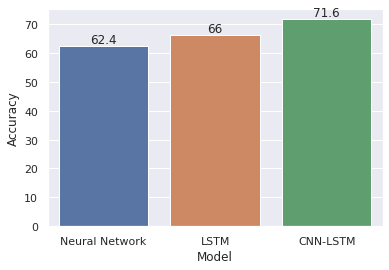

In [ ]:
# Performance plots

sns.set_theme(style="darkgrid")
sns.set_context('notebook')
ax = sns.barplot(data=model_accuracy_df, x='Model', y='Accuracy')
ax.bar_label(ax.containers[0])
plt.show()

<h4 style="color:indianred"><em>3. <ins>Choose the best performing classifier and pickle it:</ins></em></h4>

<h5 style="color:indianred"><strong>3.1 <em><ins>Hyperparameter Tuning:</ins></em></strong></h5>

In [ ]:
# Function that creates an NN model for KerasClassifier wrapper

def create_NN_wrapper(learning_rate=0.01, alpha_lr=0.6):
    """Create an NN model for KerasClassifier wrapper
    
    Args:    
        learning_rate(float): The learning rate of the model.
        alpha_lr(float): Negative slope coefficient of Leaky ReLU

    Returns:    
        model_NN(model): The compiled NN model
    """
    
    # Creating an NN classification model 
    model_NN = create_NN_model(learning_rate, alpha_lr, vocab_dim=vocab_size, embeddings=text_embedding_matrix)

    return model_NN

In [ ]:
# NN Model - Hyperparameter tuning using Grid Search Cross Validation

# Creating a KerasClassifier wrapper
model_NN_cv = KerasClassifier(build_fn=create_NN_wrapper)

# Grid Search parameters 
param_grid = {'learning_rate': [1e-2, 1e-3],
                      'alpha_lr': [0.6, 0.9],
                      'batch_size': [64, 128], 
                      'epochs': [100, 150]
                     }

# Performing grid search cross validation
grid_cv = GridSearchCV(estimator=model_NN_cv, 
                                    param_grid=param_grid,
                                    scoring='accuracy',
                                    n_jobs=-1,
                                    cv=3,
                                    verbose=0)
grid_cv.fit(X_train, y_train, verbose=0)
print(f'Best params: {grid_cv.best_params_}')
print(f'Test accuracy using the best hyperparameters: {round(grid_cv.score(X_test, y_test), 2)*100}%')

Best params: {'alpha_lr': 0.6, 'batch_size': 128, 'epochs': 150, 'learning_rate': 0.01}
5/5 [==============================] - 0s 4ms/step
Test accuracy using the best hyperparameters: 63.0%


In [ ]:
# Function that creates an LSTM model for KerasClassifier wrapper

def create_LSTM_wrapper(learning_rate=0.01, lstm_units=128):
    """Create an LSTM model for KerasClassifier wrapper
    
    Args:    
        learning_rate(float): The learning rate of the model.
        lstm_units (int): The number of units in the LSTM layer

    Returns:    
        model_LSTM(model): The compiled LSTM model
    """
    
    # Creating an LSTM classification model
    model_LSTM = create_LSTM_model(learning_rate, lstm_units, vocab_dim=vocab_size, embeddings=text_embedding_matrix)

    return model_LSTM

In [ ]:
# LSTM Model - Hyperparameter tuning using Grid Search Cross Validation

# Creating a KerasClassifier wrapper
model_LSTM_cv = KerasClassifier(build_fn=create_LSTM_wrapper)

# Grid Search parameters 
param_grid = {'learning_rate': [1e-2, 1e-3],
                      'lstm_units': [64, 128],
                      'batch_size': [64, 128], 
                      'epochs': [100, 150]
                     }

# Performing grid search cross validation
grid_cv_lstm = GridSearchCV(estimator=model_LSTM_cv, 
                                            param_grid=param_grid,
                                            scoring='accuracy',
                                            n_jobs=-1,
                                            cv=3,
                                            verbose=0)
grid_cv_lstm.fit(X_train, y_train, verbose=0) 
print(f'Best params: {grid_cv_lstm.best_params_}')
print(f'Test accuracy using the best hyperparameters: {round(grid_cv_lstm.score(X_test, y_test), 2)}')

Best params: {'batch_size': 128, 'epochs': 150, 'learning_rate': 0.01, 'lstm_units': 128}
5/5 [==============================] - 2s 24ms/step
Test accuracy using the best hyperparameters: 0.65


In [ ]:
# Function that creates a CNN-LSTM model for KerasClassifier wrapper

def create_CNN_wrapper(learning_rate=0.01, lstm_units=128):
    """Create a CNN-LSTM model for KerasClassifier wrapper
    
    Args:    
        learning_rate (float): The learning rate of the model.
        lstm_units (int): The number of units in the LSTM layer

    Returns:    
        model_CNN(model): The compiled model
    """
    
    # Creating a CNN - LSTM classification model 
    model_CNN = create_CNN_model(learning_rate, lstm_units, vocab_dim=vocab_size, embeddings=text_embedding_matrix)

    return model_CNN

In [ ]:
# CNN-LSTM Model - Hyperparameter tuning using Grid Search Cross Validation

# Creating a KerasClassifier wrapper
model_cv_cnn = KerasClassifier(build_fn=create_CNN_wrapper)

# Grid Search parameters 
param_grid = {'learning_rate': [1e-2, 1e-3],
                      'lstm_units': [64, 128],
                      'batch_size': [64, 128], 
                      'epochs': [100, 150]
                     }

# Performing grid search cross validation
grid_cv_cnn = GridSearchCV(estimator=model_cv_cnn, 
                                           param_grid=param_grid,
                                           scoring='accuracy',
                                           n_jobs=-1,
                                           cv=3,
                                           verbose=0)
grid_cv_cnn.fit(X_train, y_train, verbose=0) 
print(f'Best params: {grid_cv_cnn.best_params_}')
print(f'Test accuracy using the best hyperparameters: {round(grid_cv_cnn.score(X_test, y_test), 2)}')

Best params: {'batch_size': 128, 'epochs': 150, 'learning_rate': 0.01, 'lstm_units': 128}
5/5 [==============================] - 1s 16ms/step
Test accuracy using the best hyperparameters: 0.67


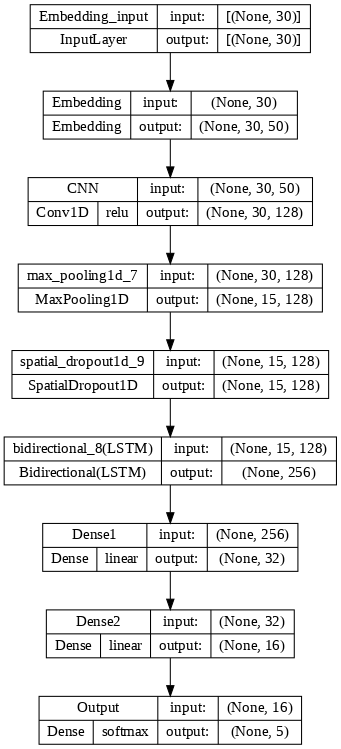

In [ ]:
# Best DL Model after hyperparameter tuning - CNN-LSTM with 'learning_rate'=0.01 and 'lstm_units'=128

model_best = create_CNN_model(learning_rate=0.01, lstm_units=128, vocab_dim=vocab_size, embeddings=text_embedding_matrix)
plot_model(model_best,
                 show_shapes=True,
                 dpi=75,
                 show_layer_names=True,
                 show_layer_activations=True)

In [ ]:
# Training the best DL model (after hyperparameter tuning)

h_callback_best = model_best.fit(X_train,
                                                 y_train, 
                                                 epochs=150,
                                                 batch_size=128,
                                                 validation_data=(X_test, y_test),
                                                 callbacks=model_callbacks())

Epoch 1/150
5/5 [==============================] - 10s 429ms/step - loss: 1.6110 - accuracy: 0.1968 - val_loss: 1.5995 - val_accuracy: 0.2411
Epoch 2/150
5/5 [==============================] - 1s 259ms/step - loss: 1.5885 - accuracy: 0.2606 - val_loss: 1.5307 - val_accuracy: 0.3050
Epoch 3/150
5/5 [==============================] - 1s 249ms/step - loss: 1.5310 - accuracy: 0.3564 - val_loss: 1.4857 - val_accuracy: 0.3830
Epoch 4/150
5/5 [==============================] - 1s 272ms/step - loss: 1.4905 - accuracy: 0.3599 - val_loss: 1.5453 - val_accuracy: 0.2624
Epoch 5/150
5/5 [==============================] - 1s 255ms/step - loss: 1.4530 - accuracy: 0.3351 - val_loss: 1.4280 - val_accuracy: 0.3830
Epoch 6/150
5/5 [==============================] - 1s 260ms/step - loss: 1.3143 - accuracy: 0.4238 - val_loss: 1.3973 - val_accuracy: 0.3972
Epoch 7/150
5/5 [==============================] - 1s 267ms/step - loss: 1.1947 - accuracy: 0.4734 - val_loss: 1.3290 - val_accuracy: 0.4397
Epoch 8/150


In [ ]:
# Evaluating the performance of the best DL model on the test data 

y_pred_prob = model_best.predict(X_test, verbose=0)
y_pred_best = [np.argmax(i) for i in y_pred_prob]

perf_metrics(y_test, y_pred_best)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88        28
           1       0.67      0.64      0.65        28
           2       0.56      0.54      0.55        28
           3       0.62      0.62      0.62        29
           4       0.96      0.93      0.95        28

    accuracy                           0.73       141
   macro avg       0.73      0.73      0.73       141
weighted avg       0.73      0.73      0.73       141

Accuracy: 73.0%


<ins><strong>Conclusion:</strong></ins>

After tuning the hyperparameters of the models using Grid Search cross validation, CNN-LSTM model with a 'learning rate'=0.01, 'lstm units'=128, 'batch size'=128 and 'epochs'=150 has given the best performance of 73% for this dataset.

The convolution layer does feature selection on the embedding vector and hence, has given a better performance when compared to the LSTM model for this dataset.

In general, tuning the hyper-parameters has not produced significant improvement in the performance of the models. Also, since the dataset is quite small, the DL models could not be trained sufficiently. Hence, ‘Text Augmentation’ using BERT contextual embeddings was considered for improving the performance of the models.

However, among the DL models used for training the given dataset, CNN-LSTM combination has outperformed the other models and has emerged as the best model so far after hyperparameter tuning.

<h5 style="color:indianred"><strong>3.2 <em><ins>Text Augmentation with 'nlpaug' - using BERT contextual embeddings</ins></em></strong></h5>

In [ ]:
# Separating the various classes in the dataset

class1 = indus_safety_preprocessed[indus_safety_preprocessed['Potential Accident Level'] == 'I']
class2 = indus_safety_preprocessed[indus_safety_preprocessed['Potential Accident Level'] == 'II']
class3 = indus_safety_preprocessed[indus_safety_preprocessed['Potential Accident Level'] == 'III']
class4 = indus_safety_preprocessed[indus_safety_preprocessed['Potential Accident Level'] == 'IV']
class5 = indus_safety_preprocessed[indus_safety_preprocessed['Potential Accident Level'] == 'V']

In [ ]:
# Synonym Augmentation with 'nlpaug' - using BERT contextual embeddings 

aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", aug_max=6)

class1_aug = aug.augment(class1['Preprocessed Description'].tolist())
class1_labels = ['I'] * 141
class1_aug_df = pd.DataFrame([class1_aug, class1_labels]).T
class1_aug_df.columns = ['Preprocessed Description', 'Potential Accident Level']

class2_aug = aug.augment(class2['Preprocessed Description'].tolist())
class2_labels = ['II'] * 141
class2_aug_df = pd.DataFrame([class2_aug, class2_labels]).T
class2_aug_df.columns = ['Preprocessed Description', 'Potential Accident Level']

class3_aug = aug.augment(class3['Preprocessed Description'].tolist())
class3_labels = ['III'] * 141
class3_aug_df = pd.DataFrame([class3_aug, class3_labels]).T
class3_aug_df.columns = ['Preprocessed Description', 'Potential Accident Level']

class4_aug = aug.augment(class4['Preprocessed Description'].tolist())
class4_labels = ['IV'] * 141
class4_aug_df = pd.DataFrame([class4_aug, class4_labels]).T
class4_aug_df.columns = ['Preprocessed Description', 'Potential Accident Level']

class5_aug = aug.augment(class5['Preprocessed Description'].tolist())
class5_labels = ['V'] * 141
class5_aug_df = pd.DataFrame([class5_aug, class5_labels]).T
class5_aug_df.columns = ['Preprocessed Description', 'Potential Accident Level']

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Augmented Dataset using BERT contextual embeddings

indus_safety_bert_augmented = pd.concat([indus_safety_preprocessed, class1_aug_df, class2_aug_df, class3_aug_df, class4_aug_df, class5_aug_df], ignore_index=True)

In [ ]:
# Comparing the shape of the preprocessed and the augmented dataset

print(f'Shape of the preprocessed dataset: {indus_safety_preprocessed.shape}')
print(f'Shape of the augmented dataset: {indus_safety_bert_augmented.shape}')

Shape of the preprocessed dataset: (705, 2)
Shape of the augmented dataset: (1410, 2)


<em><strong>Observation:</strong></em> After data augmentation, the dataset has become twice the size of the original dataset

<h5 style="color:indianred"><strong><em><ins>Text preprocessing for the augmented dataset:</ins></em></strong></h5>

In [ ]:
# Building the dictionary of indices for the augmented dataset

description_text_aug = indus_safety_bert_augmented['Preprocessed Description']

text_aug_tokenizer= Tokenizer()
text_aug_tokenizer.fit_on_texts(description_text_aug)

In [ ]:
# Changing  texts into sequence of indexes

description_idx_aug = text_aug_tokenizer.texts_to_sequences(description_text_aug)

In [ ]:
# Padding the sequences to make all the sequences have the same lengths

description_idx_aug = pad_sequences(description_idx_aug, max_seq_len, padding='post', truncating='post')

In [ ]:
# Splitting the data into features X and labels y

X_aug = description_idx_aug
y_aug = indus_safety_bert_augmented['Potential Accident Level']

In [ ]:
# Label Encoding the target variable

y_enc_aug = y_aug.astype('category').cat.codes.values

In [ ]:
# Splitting the augmented data into train and test

X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_aug, y_enc_aug, test_size=0.20, random_state=42, stratify=y_enc_aug)

In [ ]:
display(X_train_aug.shape, X_test_aug.shape, y_train_aug.shape, y_test_aug.shape)

(1128, 30)

(282, 30)

(1128,)

(282,)

In [ ]:
# Getting the augmented vocabulary size

vocab_size_aug = len(text_aug_tokenizer.word_index)
print(f'vocabulary size: {vocab_size_aug}')

vocabulary size: 3564


<ins><strong>Insight:</strong></ins> Since data augmentation has led to an increase in the number of words in the vocabulary, the 'vocabulary size’ of the augmented dataset has increased when compared to the original dataset.


In [ ]:
# Extracting the Weight matrix using GloVe embeddings for the augmented vocabulary

text_aug_embedding_matrix = filter_glove_words(text_aug_tokenizer.index_word, glove_vectors_dict, embedding_dim)

In [ ]:
# Dataframe to store the accuracy of the DL models with the augmented dataset
    
aug_model_accuracy_df = pd.DataFrame()

In [ ]:
# Designing and training a Neural Network classifier with the BERT augmented dataset

model_NN_aug = create_NN_model(learning_rate=0.001, alpha_lr=0.6, vocab_dim=vocab_size_aug, embeddings=text_aug_embedding_matrix)
h_callback_aug = model_NN_aug.fit(X_train_aug,
                                                      y_train_aug, 
                                                      epochs=100,
                                                      batch_size=128,
                                                      validation_data=(X_test_aug, y_test_aug),
                                                      callbacks=model_callbacks())

Epoch 1/100
9/9 [==============================] - 2s 43ms/step - loss: 1.6107 - accuracy: 0.2234 - val_loss: 1.6093 - val_accuracy: 0.1986
Epoch 2/100
9/9 [==============================] - 0s 12ms/step - loss: 1.6049 - accuracy: 0.2207 - val_loss: 1.6091 - val_accuracy: 0.2340
Epoch 3/100
9/9 [==============================] - 0s 13ms/step - loss: 1.5692 - accuracy: 0.3129 - val_loss: 1.6085 - val_accuracy: 0.2979
Epoch 4/100
9/9 [==============================] - 0s 12ms/step - loss: 1.5392 - accuracy: 0.3644 - val_loss: 1.6069 - val_accuracy: 0.4255
Epoch 5/100
9/9 [==============================] - 0s 11ms/step - loss: 1.4859 - accuracy: 0.4202 - val_loss: 1.6030 - val_accuracy: 0.4752
Epoch 6/100
9/9 [==============================] - 0s 13ms/step - loss: 1.4272 - accuracy: 0.4583 - val_loss: 1.5959 - val_accuracy: 0.5319
Epoch 7/100
9/9 [==============================] - 0s 11ms/step - loss: 1.3575 - accuracy: 0.4973 - val_loss: 1.5849 - val_accuracy: 0.5851
Epoch 8/100
9/9 [===

In [ ]:
# Evaluating the NN model accuracy for the Neural Network model with augmented data

accuracy_NN_aug = model_NN_aug.evaluate(X_test_aug, y_test_aug,verbose=0)[1]
aug_model_accuracy_df = aug_model_accuracy_df.append(pd.DataFrame(['Neural Network classifier', round(accuracy_NN_aug, 4)*100]).T, ignore_index=True)

print(f'Test accuracy: {round(accuracy_NN_aug, 4)*100}%')

Test accuracy: 89.72%


In [ ]:
# Function to plot training and validation loss and accuracy values

def plot_loss_accuracy(loss, val_loss, acc, val_acc):
    """Plot the training and the validation loss and accuracy values.
    
    Args:    
        loss(list): The training loss.
        val_loss(list): The Validation loss.
        acc(list): The training accuracy.
        val_acc(list): The Validation accuracy.
    """
    sns.set_style('white')
    sns.set_context('notebook')
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    ax0.plot(loss)
    ax0.plot(val_loss)
    ax0.set(title='Model loss', xlabel='Epoch', ylabel='Loss')
    ax0.legend(['Train', 'Validation'], loc='upper right')

    ax1.plot(acc)
    ax1.plot(val_acc)
    ax1.set(title='Model accuracy', xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

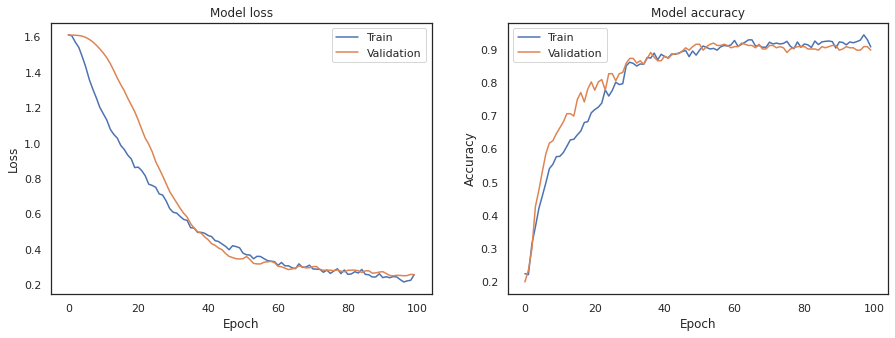

In [ ]:
# Training and Validation Loss and Accuracy plots for the Neural Network classifier

sns.set_theme(style='white')
plot_loss_accuracy(h_callback_aug.history['loss'], h_callback_aug.history['val_loss'], h_callback_aug.history['accuracy'], h_callback_aug.history['val_accuracy'])

<ins><b>Insight:</b></ins> For the NN classifier, the accuracy and loss learning curves seem to stabilize after 80-100 epochs. If the model continues to train beyond this, it might lead to overfitting. Hence, it represents a good fit learning curve.

In [ ]:
# Evaluating the performance of the Neural Network classifier on the augmented test data 

y_pred_prob = model_NN_aug.predict(X_test_aug, verbose=0)
y_pred_NN_aug = [np.argmax(i) for i in y_pred_prob]

perf_metrics(y_test_aug, y_pred_NN_aug)

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95        57
           1       0.91      0.89      0.90        56
           2       0.85      0.84      0.85        56
           3       0.77      0.82      0.80        57
           4       1.00      1.00      1.00        56

    accuracy                           0.90       282
   macro avg       0.90      0.90      0.90       282
weighted avg       0.90      0.90      0.90       282

Accuracy: 89.7%


In [ ]:
# Designing and training an LSTM classifier with the BERT augmented dataset

model_LSTM_aug = create_LSTM_model(learning_rate=0.01, lstm_units=128, vocab_dim=vocab_size_aug, embeddings=text_aug_embedding_matrix)
h_callback_LSTM_aug = model_LSTM_aug.fit(X_train_aug,
                                                                   y_train_aug, 
                                                                   epochs=100,
                                                                   batch_size=128,
                                                                   validation_data=(X_test_aug, y_test_aug),
                                                                   callbacks=model_callbacks())

Epoch 1/100
9/9 [==============================] - 11s 508ms/step - loss: 1.6117 - accuracy: 0.1924 - val_loss: 1.6045 - val_accuracy: 0.2553 - lr: 0.0100
Epoch 2/100
9/9 [==============================] - 4s 400ms/step - loss: 1.6107 - accuracy: 0.2154 - val_loss: 1.6059 - val_accuracy: 0.1950 - lr: 0.0100
Epoch 3/100
9/9 [==============================] - 4s 433ms/step - loss: 1.6044 - accuracy: 0.1897 - val_loss: 1.5656 - val_accuracy: 0.2447 - lr: 0.0100
Epoch 4/100
9/9 [==============================] - 4s 405ms/step - loss: 1.5993 - accuracy: 0.2518 - val_loss: 1.5714 - val_accuracy: 0.2482 - lr: 0.0100
Epoch 5/100
9/9 [==============================] - 4s 435ms/step - loss: 1.5228 - accuracy: 0.3298 - val_loss: 1.4836 - val_accuracy: 0.3617 - lr: 0.0100
Epoch 6/100
9/9 [==============================] - 4s 420ms/step - loss: 1.4392 - accuracy: 0.3564 - val_loss: 1.3534 - val_accuracy: 0.3972 - lr: 0.0100
Epoch 7/100
9/9 [==============================] - 4s 421ms/step - loss: 1.

In [ ]:
# Evaluating the LSTM model accuracy on the augmented test data

accuracy_LSTM_aug = model_LSTM_aug.evaluate(X_test_aug, y_test_aug, verbose=0)[1]
aug_model_accuracy_df = aug_model_accuracy_df.append(pd.DataFrame(['LSTM classifier', round(accuracy_LSTM_aug, 4)*100]).T, ignore_index=True)

print(f'Test accuracy: {round(accuracy_LSTM_aug, 4)*100}%')

Test accuracy: 91.13%


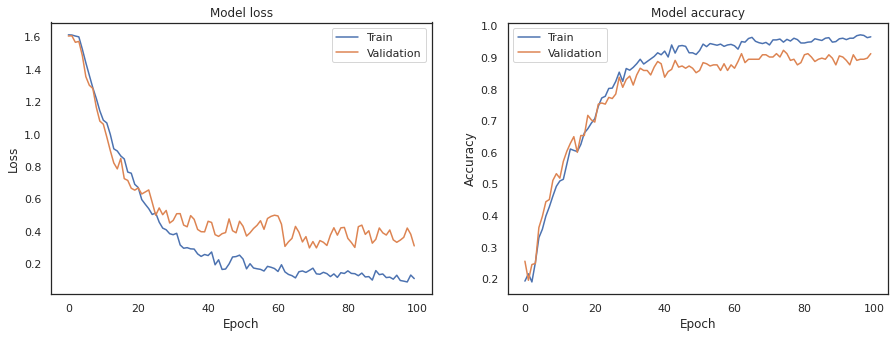

In [ ]:
# Training and Validation Loss and Accuracy plots for the LSTM model with augmented data

sns.set_theme(style='white')
plot_loss_accuracy(h_callback_LSTM_aug.history['loss'], h_callback_LSTM_aug.history['val_loss'], h_callback_LSTM_aug.history['accuracy'], h_callback_LSTM_aug.history['val_accuracy'])

<ins><b>Insight:</b></ins> For the LSTM classifiers, there seems to be a small "generalization gap" between the train and validation accuracy and loss learning curves, indicating some amount of overfitting. In spite of using ‘dropouts’ and 'recurrent dropouts’ in the Bidirectional LSTM layer for regularization, this ‘generalisation gap’ could not be reduced any further without suffering a loss in accuracy.

In [ ]:
# Evaluating the performance of the LSTM classifier on the augmented test data 

y_pred_prob = model_LSTM_aug.predict(X_test_aug, verbose=0)
y_pred_LSTM_aug = [np.argmax(i) for i in y_pred_prob]

perf_metrics(y_test_aug, y_pred_LSTM_aug)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        57
           1       0.93      0.91      0.92        56
           2       0.92      0.82      0.87        56
           3       0.79      0.91      0.85        57
           4       0.95      0.96      0.96        56

    accuracy                           0.91       282
   macro avg       0.92      0.91      0.91       282
weighted avg       0.92      0.91      0.91       282

Accuracy: 91.10000000000001%


In [ ]:
# Designing and training an CNN-LSTM classifier with the BERT augmented dataset

model_CNN_aug = create_CNN_model(learning_rate=0.01, lstm_units=128, vocab_dim=vocab_size_aug, embeddings=text_aug_embedding_matrix)
h_callback_CNN_aug = model_CNN_aug.fit(X_train_aug,
                                                                y_train_aug, 
                                                                epochs=100,
                                                                batch_size=128,
                                                                validation_data=(X_test_aug, y_test_aug),
                                                                callbacks=model_callbacks())

Epoch 1/100
9/9 [==============================] - 10s 365ms/step - loss: 1.6056 - accuracy: 0.2314 - val_loss: 1.5643 - val_accuracy: 0.2872
Epoch 2/100
9/9 [==============================] - 3s 296ms/step - loss: 1.5043 - accuracy: 0.3431 - val_loss: 1.3280 - val_accuracy: 0.4433
Epoch 3/100
9/9 [==============================] - 3s 303ms/step - loss: 1.3258 - accuracy: 0.4424 - val_loss: 1.2354 - val_accuracy: 0.4645
Epoch 4/100
9/9 [==============================] - 3s 289ms/step - loss: 1.1749 - accuracy: 0.5035 - val_loss: 1.0212 - val_accuracy: 0.5567
Epoch 5/100
9/9 [==============================] - 3s 296ms/step - loss: 1.0140 - accuracy: 0.5319 - val_loss: 0.8970 - val_accuracy: 0.6028
Epoch 6/100
9/9 [==============================] - 3s 294ms/step - loss: 0.8818 - accuracy: 0.5984 - val_loss: 0.8430 - val_accuracy: 0.6241
Epoch 7/100
9/9 [==============================] - 3s 295ms/step - loss: 0.7257 - accuracy: 0.6809 - val_loss: 0.7996 - val_accuracy: 0.6631
Epoch 8/100


In [ ]:
# Evaluating the CNN-LSTM model accuracy on the test data

accuracy_CNN_aug = model_CNN_aug.evaluate(X_test_aug, y_test_aug, verbose=0)[1]
aug_model_accuracy_df = aug_model_accuracy_df.append(pd.DataFrame(['CCN-LSTM Classifier', round(accuracy_CNN_aug, 3)*100]).T, ignore_index=True)


print(f'Test accuracy: {round(accuracy_CNN_aug, 3)*100}%')

Test accuracy: 88.3%


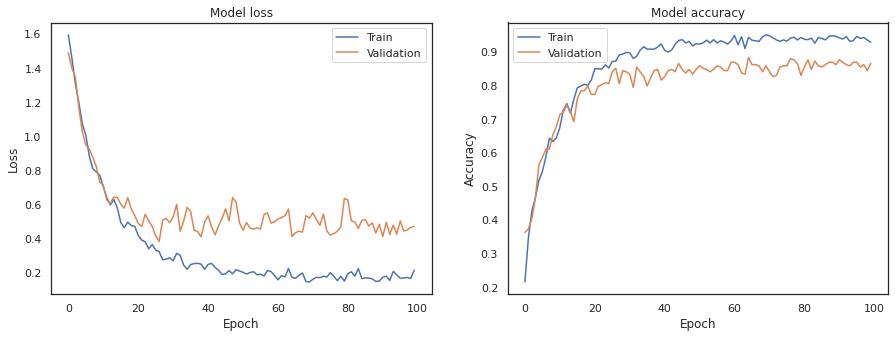

In [ ]:
# Training and Validation Loss and Accuracy plots for the CNN-LSTM model with augmented data

sns.set_theme(style='white')
plot_loss_accuracy(h_callback_CNN_aug.history['loss'], h_callback_CNN_aug.history['val_loss'], h_callback_CNN_aug.history['accuracy'], h_callback_CNN_aug.history['val_accuracy'])

<ins><b>Insight:</b></ins> Just like the LSTM model, the CNN-LSTM classifier, also seems to have a small "generalization gap" between the train and validation accuracy and loss learning curves, indicating some amount of overfitting. In spite of using ‘dropouts’ and 'recurrent dropouts’ in the LSTM layer for regularization, this ‘generalisation gap’ could not be reduced any further without suffering a loss in accuracy

In [ ]:
# Evaluating the performance of the CNN-LSTM classifier on the augmented test data 

y_pred_prob = model_CNN_aug.predict(X_test_aug, verbose=0)
y_pred_CNN_aug = [np.argmax(i) for i in y_pred_prob]

perf_metrics(y_test_aug, y_pred_CNN_aug)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89        57
           1       0.89      0.88      0.88        56
           2       0.90      0.80      0.85        56
           3       0.85      0.79      0.82        57
           4       0.93      1.00      0.97        56

    accuracy                           0.88       282
   macro avg       0.88      0.88      0.88       282
weighted avg       0.88      0.88      0.88       282

Accuracy: 88.3%


In [ ]:
# Performance of DL models with Augmented data

aug_model_accuracy_df.columns = ['Model', 'Accuracy after Text Augmentation']
aug_model_accuracy_df

,Model,Accuracy after Text Augmentation
0,Neural Network classifier,89.72
1,LSTM classifier,91.13
2,CCN-LSTM Classifier,88.3


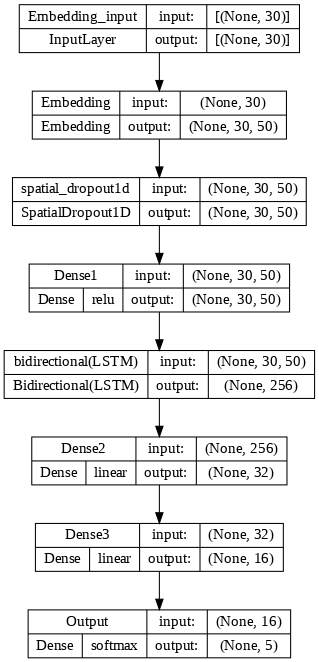

In [ ]:
# Best Model after text augmentation - Bidirectional LSTM with 'learning_rate'=0.01 and 'lstm_units'=128 

best_model = model_LSTM_aug
plot_model(best_model,
                 show_shapes=True,
                 dpi=75,
                 show_layer_names=True,
                 show_layer_activations=True)

<ins><strong>Conclusion:</strong></ins>

After text augmentation with 'nlpaug' library using BERT contextual embeddings, there has been a significant improvement in the performance of the DL models. 

The 'Bidirectional LSTM model' has given the best performance of 91.1%. This is a significant improvement over 66% after hyperparameter tuning. Also, the precision, the recall and the F1 scores are 92%, 91% and 91% respectively, indicating a well-balanced model.

Initially, since the dataset was very small, the DL models could not be trained sufficiently. However, after ‘synonym substitution’ using BERT contextual embeddings, the performance of the models improved significantly.


In [ ]:
# Pickling the best model 

saved_best_model = pickle.dumps(best_model)

In [ ]:
# Saving the best model in the disk

pickled_file = open('/content/drive/MyDrive/AIML/Capstone/best_model.pickle', 'wb')
pickle.dump(best_model, pickled_file)
pickled_file.close()